## pythonでjpegファイルのバイナリデータから画素値情報を取り出すトライアル。

pythonのコーディングを学ぶ課題としてjpegフォーマットをバイナリデータから画素値に変換するトライアルをしてみる。
すこし符合理論や信号処理の復習も兼ねる

参考にしたサイト
* [https://www.setsuki.com/hsp/ext/jpg.htm](https://www.setsuki.com/hsp/ext/jpg.htm)
* [https://hp.vector.co.jp/authors/VA032610/JPEGFormat/StructureOfJPEG.htm](https://hp.vector.co.jp/authors/VA032610/JPEGFormat/StructureOfJPEG.htm)
* [http://www.siisise.net/jpeg.html](http://www.siisise.net/jpeg.html)
* [https://www.w3.org/Graphics/JPEG/jfif3.pdf](https://www.w3.org/Graphics/JPEG/jfif3.pdf)
* [http://www.ijg.org/files/T-REC-T.871-201105-I!!PDF-E.pdf](http://www.ijg.org/files/T-REC-T.871-201105-I!!PDF-E.pdf)
* [https://www.w3.org/Graphics/JPEG/itu-t81.pdf0](https://www.w3.org/Graphics/JPEG/itu-t81.pdf)
* [http://www.ijg.org/files/Wallace.JPEG.pdf](http://www.ijg.org/files/Wallace.JPEG.pdf)

とりあえずターゲットのjpegファイルを表示しておく(matplotlib使えば簡単に変換・描画できる、、)

[]

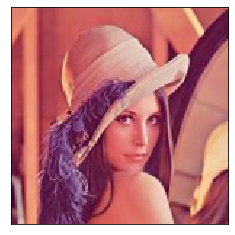

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


f_name="target_data\Lenna.jpg"

img = mpimg.imread(f_name) #jpegファイルの読み込み

imgplot = plt.imshow(img)  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除

### 1.jpegファイルのHEXダンプ

"rb"モードでファイルをオープンし、バイナリデータとしてjpgファイルをbytes型の配列sとして読み込み、16データ1行単位でhexダンプ出力  
データ量の都合途中まで(16\*32\*3= 1536bytes)の出力とする。


In [2]:
f=open(f_name,"rb")
s=f.read()
f.close


cnt=0
rows=0

for byte in s:  
    if( rows == 32 * 2 and cnt%16==0 ): break
    if (cnt%16==0):
        if(rows %32 ==0 ):       
            print("")
            print("       ",end="")
            for i in range(16):
                print(" {:1x} ".format(i),end="")
            print("")
        print("{:03x}# : ".format(rows),end="")
        
    print("{:02x} ".format(byte),end="")
 
    cnt+=1
    if (cnt%16==0):
        print("")
        rows+=1
        
print("")    
print ("......(omittion)")



        0  1  2  3  4  5  6  7  8  9  a  b  c  d  e  f 
000# : ff d8 ff e0 00 10 4a 46 49 46 00 01 01 01 00 48 
001# : 00 48 00 00 ff db 00 43 00 05 03 04 04 04 03 05 
002# : 04 04 04 05 05 05 06 07 0c 08 07 07 07 07 0f 0b 
003# : 0b 09 0c 11 0f 12 12 11 0f 11 11 13 16 1c 17 13 
004# : 14 1a 15 11 11 18 21 18 1a 1d 1d 1f 1f 1f 13 17 
005# : 22 24 22 1e 24 1c 1e 1f 1e ff db 00 43 01 05 05 
006# : 05 07 06 07 0e 08 08 0e 1e 14 11 14 1e 1e 1e 1e 
007# : 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 
008# : 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 
009# : 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e ff c0 
00a# : 00 11 08 00 96 00 96 03 01 22 00 02 11 01 03 11 
00b# : 01 ff c4 00 1f 00 00 01 05 01 01 01 01 01 01 00 
00c# : 00 00 00 00 00 00 00 01 02 03 04 05 06 07 08 09 
00d# : 0a 0b ff c4 00 b5 10 00 02 01 03 03 02 04 03 05 
00e# : 05 04 04 00 00 01 7d 01 02 03 00 04 11 05 12 21 
00f# : 31 41 06 13 51 61 07 22 71 14 32 81 91 a1 08 23 
010# : 42 b1 c1 15 52 d1 f0 24 33 62 72 82 09 0

### 2.pegファイルのマーカー/セグメント/イメージデータ構造の抽出

バイナリデータをバイト単位でチェックし0xFFXX のパターン(マーカー)を検出した場合セグメントとして処理し
セグメント名(辞書定義されていればその文字列、それ以外ならHEX文字列)、セグメント長、セグメントデータ(bytes型)を取り出し、リストjpeg_structに追加。

"SOI","EOI"に関してはマーカーのみなので、セグメント長、セグメントデータなしとしてがjpeg_structリスト上はセグメントと同列に扱う

"SOS"セグメント以降はイメージデータとして"EOI"を検知するまでのデータをイメージデータとして文字列"IMG"及びそのサイズ、データ(bytes型)をリストjpeg_structリストに追加(イメージデータはセグメントではないがjpeg_structリスト上は名称"IMG"をつけてセグメントと同列に扱うことにする)

マーカー0xFF00に関しては0x00のバイナリデータとして変換する。

In [3]:
marker_def={0xd8:"SOI",0xd9:"EOI",0xda:"SOS",0xe0:"APP0",0xdb:"DQT",0xc0:"SOF0",0xc2:"SOF2",0xc4:"DHT"}

flag_marker= False
flag_seg=False
flag_seg_cnt=False
flag_seg_data=False
flag_SOI= False
flag_EOI= False
flag_SOS= False
flag_err=False
jpeg_struct=[]
seg_buf=[]
byte_bufs=b''
seg_count=0

f=open(f_name,"rb")
s=f.read()
f.close


for byte in s:
    if flag_marker==False and byte==0xff :  #マーカーの判定
        flag_marker=True
        
    else:
        
        #######    マーカー処理  #########
        if flag_marker==True :  
            #FF00マーカ処理
            if byte==0x00 :
                #print("0xFF00")
                byte_bufs=byte_bufs+bytes.fromhex("{:02X}".format(0xff))              
            #辞書定義済みマーカ
            elif byte in marker_def: 
                #SOI判定       
                if flag_SOI==False :
                    if marker_def[byte]=="SOI" :           
                        flag_SOI=True
                        jpeg_struct=jpeg_struct+[["SOI"]]
                    else:
                        flag_err=True;
                        
                #EOI判定    
                elif marker_def[byte]=="EOI":               
                    #IMAGE DATA格納
                    #jpeg_struct=jpeg_struct+[["IMG","{:d}".format(len(byte_bufs)),byte_bufs.hex()]] 
                    jpeg_struct=jpeg_struct+[["IMG","{:d}".format(len(byte_bufs)),byte_bufs]]
                    jpeg_struct=jpeg_struct+[["EOI"]] 
                    flag_EOI=True    
                    
                #その他定義済マーカ（セグメント処理）
                elif byte in marker_def:               
                    seg_buf=[""+marker_def[byte]]
                    flag_seg=True
                    #SOS判定
                    if marker_def[byte]=="SOS":
                        flag_SOS=True
                        
            #未定義マーカ（セグメント処理）
            else:                          
                seg_buf=["FF{:X}".format(byte)]
                flag_seg=True
            
            flag_marker=False
        
        else:
            #セグメント処理
            if flag_seg==True:
                if(flag_seg_cnt==False):
                    seg_count=seg_count+1
                    seg_size_h=byte
                    flag_seg_cnt=True
                elif(flag_seg_data==False):
                    seg_size=seg_size_h*256+byte
                    seg_buf=seg_buf+["{:d}".format(seg_size)]
                    seg_size=seg_size-2
                    byte_bufs=b''
                    flag_seg_data=True
                else:
                    byte_bufs=byte_bufs+bytes.fromhex("{:02X}".format(byte))
                    seg_size=seg_size-1
                    if seg_size==0:
                        #seg_buf=seg_buf+[byte_bufs.hex()]
                        seg_buf=seg_buf+[byte_bufs]
                        jpeg_struct=jpeg_struct+[seg_buf]
                        byte_bufs=b''
                        flag_seg=False
                        flag_seg_cnt=False
                        flag_seg_data=False
                        
            #IMAGE DATA処理 (SOSセグメント後)
            elif flag_SOS==True and flag_seg==False:                  
                byte_bufs=byte_bufs+bytes.fromhex("{:02X}".format(byte))
                
            #例外処理
            else:
                flag_err=True
        
    
    if flag_err==True or flag_EOI==True:
        break;

                
if flag_err==False and flag_EOI==True:
    print("Succeeded!!")


Succeeded!!


一応終了したときに一定のつじつまが合ってると"Succeeded!!"と出力するようにしておいたつもりなのでたぶん成功

次は抽出したjpegファイルの構造(リスト型 jpeg_struct)の出力

len()関数でセグメント(含：マーカのみ/イメージデータ)の数を出力

In [4]:
len(jpeg_struct)

12

各セグメントのマーカーの表示

In [5]:
i=0
for seg in jpeg_struct:
    print("Seg ",i," : ",seg[0],sep="") 
    i+=1

Seg 0 : SOI
Seg 1 : APP0
Seg 2 : DQT
Seg 3 : DQT
Seg 4 : SOF0
Seg 5 : DHT
Seg 6 : DHT
Seg 7 : DHT
Seg 8 : DHT
Seg 9 : SOS
Seg 10 : IMG
Seg 11 : EOI


jpeg_sructリストの一部を中身のぞいてみる。

In [6]:
jpeg_struct[0]

['SOI']

In [7]:
jpeg_struct[1]

['APP0', '16', b'JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00']

In [8]:
jpeg_struct[2]

['DQT',
 '67',
 b'\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x05\x05\x06\x07\x0c\x08\x07\x07\x07\x07\x0f\x0b\x0b\t\x0c\x11\x0f\x12\x12\x11\x0f\x11\x11\x13\x16\x1c\x17\x13\x14\x1a\x15\x11\x11\x18!\x18\x1a\x1d\x1d\x1f\x1f\x1f\x13\x17"$"\x1e$\x1c\x1e\x1f\x1e']

イメージデータ(jpeg_struct\[10\])は大きいのでデータ内容jpeg_struct\[10\]\[2\]の出力は省略

In [9]:
jpeg_struct[10][0],jpeg_struct[10][1]

('IMG', '6594')

In [10]:
jpeg_struct[11]

['EOI']

### 3.各セグメントの解析

jpeg_structの各セグメントのデータよりセグメントを構成するパラメータを出力する。  
(格納する形式を決めてないのでとりあえず印字出力のみとする、、)

サポートするセグメント(マーカー)もとりあえず以下に限定する(基本JFIF形式に限定)
* SOI
* APP0 JFIFフォーマット
* DHT ハフマンテーブル
* SOF フレームヘッダ(SOF0,2のみ)
* DQT 量子化テーブル
* SOS スキャンヘッダ
* EOI

In [11]:
flag_SOI= False
flag_EOI= False
flag_SOS= False
flag_err=False          

for seg in jpeg_struct:
    print(seg[0])

    if(seg[0] == "IMG"):
        print("  DATA LENGTH : ",seg[1],sep="")
    else:

        if(seg[0] == "SOI"):
            flag_SOI=True
        elif(seg[0] == "EOI"):
            flag_EOI=True
        else:
            print("  SEG LENGTH : ",seg[1])
            data=seg[2]

            
            ########       APP0   JFIFフォーマット       ######

            if(seg[0] == "APP0"):
                print("  ID : ",data[0:4].decode(),sep="")    #JFIF識別子
                print("  Ver : ",data[5],".",data[6],sep="")  #バージョン番号
                print("  U : ",data[7],sep="")                #ピクセル濃度の単位 0:不定 1:pixels/inch(dpi) 3: pixel/cm　
                print("  Xd : ",data[8]*256+data[9],sep="")   #縦のピクセル濃度
                print("  Yd : ",data[10]*256+data[11],sep="") #横のピクセル濃度
                print("  Xt : ",data[12],sep="")              #サムネイルイメージの横幅(サムネイル無なら0)
                print("  Yt : ",data[13],sep="")              #サムネイルイメージの高さ(サムネイル無なら0)             
                for i in range(data[12]*data[13]):          
                    print("  RGB",i," : (",data[14+i*3],",",data[15+i*3],",",data[16+i*3],")",sep="")
                                                                          #サムネイルイメージRGB値                    
                        
                        
            ########       DQT   量子化テーブル定義      ######

            elif(seg[0] == "DQT"):
                length = int(seg[1])-3
                base = 0
                while(length >0):
                    pqn=data[base]>>4
                    tqn=data[base]&0x0F;
                    if(pqn==0):
                        qlen=64;
                    else:
                        qlen=128;
                    print("  Pq",tqn," : ",pqn,sep="")         #量子化テーブル精度 0;8bit , 1:16bit
                    print("  Tq",tqn," : ",tqn,sep="")         #量子化テーブル番号 0 to 3
                    for i in range(qlen):
                        print("  Q",tqn,"-",ascii(i)," : ",data[base+1+i],sep="")
                                                               #量子化因子(量子化係数)
                    length-=qlen+1
                    base+=qlen+1

                    
            ########       SOF0 フレームタイプ0開始　(Baseline-DCT & ハフマン符号)   ######
            
            elif(seg[0] == "SOF0" or seg[0] == "SOF2"):
                nf=data[5]
                print("  P : ",data[1])                             #サンプルの精度
                print("  Y : ",data[1]*256+data[2],sep="")         #画像縦サイズ
                print("  X : ",data[3]*256+data[4],sep="")         #画像横サイズ
                print("  Nf : ",data[5])                           #構成要素数 1;GreyScacle ,3;YCbCr or YIQ 4;CMYK
                for i in range(nf):
                    print("  C",i+1," : ",data[6+i*3],sep="")      #構成要素 識別子 1:Y 2:Cb 3:Cr 4:I 5:Q
                    print("  H",i+1," : ",data[7+i*3]>>4,sep="")   #構成要素サ 水平方向ンプル化要因(比率)
                    print("  V",i+1," : ",data[7+i*3]&0x0F,sep="") #構成要素 垂直報告サンプル化要因(比率)
                    print("  Tq",i+1," : ",data[8+i*3],sep="")     #構成要素 量子化テーブル番号
 
            ########       DHT   ハフマン符号テーブル定義      ######

            elif(seg[0] == "DHT"):
                thn=data[0]&0x0f
                tcn=data[0]>>4
                print("  Tc",thn," : ",tcn,sep="")                          #クラス 0;DC , 1:1AC ？？
                print("  Th",thn," : ",thn,sep="")                          #ハフマン符号テーブル番号
                vlen=[]
                for i in range(16):
                    vlen+= [data[1+i]]
                    print("  L",i+1," ; ",data[1+i],sep="")          #符号長ごとの符号数
                
                base = 17

                for i in range(16):
                    for j in range(vlen[i]):
                        if(tcn==0):
                            print("  V",i+1,"-",j+1," : ",data[base+j],sep="")
                                                   #各符号長の符号(tcn=0のとき)　データービット数
                        else:
                            print("  V",i+1,"-",j+1," : ",data[base+j]>>4,",",data[base+j]&0x0F,sep="")
                                                   #各符号長の符号(tcn=1のとき) ランレングス数、データービット数                         
                            
                    base+=vlen[i]

            ########       SOS   Start Of Scan      ######                    
                    
            elif(seg[0] == "SOS"):
                ns=data[0]
                print("  Ns : ",ns)                                   #構成要素の数
                
                for i in range(ns):
                    print("  Cs",i+1," : ",data[1+i*2],sep="")        #構成要素 識別子
                    print("  Td",i+1," : ",data[2+i*2]>>4,sep="")     #構成要素 DC成分ハフマン符号テーブル番号
                    print("  Ta",i+1," : ",data[2+i*2]&0x0F,sep="")   #構成要素 AC成分ハフマン符号テーブル番号
                    
                print("  Ss : ",data[1+ns*2],sep="")                   #スペクトル選択開始(量子化係数開始番号)
                print("  Se : ",data[2+ns*2],sep="")                   #スペクトル選択終了量子化係数開始終了)
                print("  Ah : ",data[3+ns*2]>>4,sep="")                #？？
                print("  Al : ",data[3+ns*2]&0x0f,sep="")              #？？
                
                

SOI
APP0
  SEG LENGTH :  16
  ID : JFIF
  Ver : 1.1
  U : 1
  Xd : 72
  Yd : 72
  Xt : 0
  Yt : 0
DQT
  SEG LENGTH :  67
  Pq0 : 0
  Tq0 : 0
  Q0-0 : 5
  Q0-1 : 3
  Q0-2 : 4
  Q0-3 : 4
  Q0-4 : 4
  Q0-5 : 3
  Q0-6 : 5
  Q0-7 : 4
  Q0-8 : 4
  Q0-9 : 4
  Q0-10 : 5
  Q0-11 : 5
  Q0-12 : 5
  Q0-13 : 6
  Q0-14 : 7
  Q0-15 : 12
  Q0-16 : 8
  Q0-17 : 7
  Q0-18 : 7
  Q0-19 : 7
  Q0-20 : 7
  Q0-21 : 15
  Q0-22 : 11
  Q0-23 : 11
  Q0-24 : 9
  Q0-25 : 12
  Q0-26 : 17
  Q0-27 : 15
  Q0-28 : 18
  Q0-29 : 18
  Q0-30 : 17
  Q0-31 : 15
  Q0-32 : 17
  Q0-33 : 17
  Q0-34 : 19
  Q0-35 : 22
  Q0-36 : 28
  Q0-37 : 23
  Q0-38 : 19
  Q0-39 : 20
  Q0-40 : 26
  Q0-41 : 21
  Q0-42 : 17
  Q0-43 : 17
  Q0-44 : 24
  Q0-45 : 33
  Q0-46 : 24
  Q0-47 : 26
  Q0-48 : 29
  Q0-49 : 29
  Q0-50 : 31
  Q0-51 : 31
  Q0-52 : 31
  Q0-53 : 19
  Q0-54 : 23
  Q0-55 : 34
  Q0-56 : 36
  Q0-57 : 34
  Q0-58 : 30
  Q0-59 : 36
  Q0-60 : 28
  Q0-61 : 30
  Q0-62 : 31
  Q0-63 : 30
DQT
  SEG LENGTH :  67
  Pq1 : 0
  Tq1 : 1
  Q1-0 : 5
  Q1

各セグメントの要素は抽出できたと思われる。  
次にハフマン符号化されたイメージデータから8x8ブロック単位のDCTのスペクトルデータに復号していくわけだが、、、  
DHTとかDQTとかの中身の意味についてもう少し調査が必要  

jpegではを基本8x8ブロック単位のDCTスペクトルをデータとして持っているが、その8x8ブロックのデータの格納順は以下の表の通り(ジグザグスキャン)で復号化した値を展開していく。  
因みに下に行くほど垂直周波数が高く、右に行くほど水平周波数が高く0番目のデータ(左上)がDC成分でそのほかがAC成分ということになる。 



|  ||  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |
|- ||:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|0 ||  0 |  1 |  5 |  6 | 14 | 15 | 27 | 28 |
|1 ||  2 |  4 |  7 | 13 | 16 | 26 | 29 | 42 |
|2 ||  3 |  8 | 12 | 17 | 25 | 30 | 41 | 43 |
|3 ||  9 | 11 | 18 | 24 | 31 | 40 | 44 | 53 |
|4 || 10 | 19 | 23 | 32 | 39 | 45 | 52 | 54 |
|5 || 20 | 22 | 33 | 38 | 46 | 51 | 55 | 60 |
|6 || 21 | 34 | 37 | 47 | 50 | 56 | 59 | 61 |
|7 || 35 | 36 | 48 | 49 | 57 | 58 | 62 | 63 |


復号化された64個のデータ列のにこの表で対応する量子化テーブルTq0～3の内容(Q-0～63)の値をかけると所望のスペクトル値が求まるとのこと  

実際の量子化テーブルTQHもQnのnが小さい(DC～低周波)あたりは小さな数字で、nが大きい(高周波)のところは大きめの値になっていて、jpegでは低周波域は密な量子化(DCT変換した結果を少ない値で割って丸める)、高周波域程、疎な量子化(大きい値で割る)していることがわかる。(そうすることで高周波域データの情報量を減らしている模様)  
実際高周波域のデータは荒くても実際目立たない。 

量子化テーブルは以上のような仕組みなようで、ブロック単位の復号さえできてしてしまえば復号データ列と量子化テーブルのデータ列の要素ごとの掛け算をすることでDCTスペクトル値を再現するのは簡単にできそう。

マーカAPP0でID="JFIF"指定されるJFIFフォーマットの場合カラー画像はYCrCbの3成分の値(1成分1byte)をつかう。  
(色差成分はCB,Crは負数もとりえるため実データは128(0x80)オフセットされて1バイトのunsigned intとしてあつかっている。)  
SOF0で各成分に対応した量子化テーブル番号が指定されている。 
今回の例ではYはテーブル0でCb,Crはテーブル  

成分1  
C1=1 (Y)  
Tq1=0(量子化テーブル0)  
H1=2  
V1=2  

成分2  
C2=2(Cr)  
Tq2=1  
H2=1  
V2=1  

成分2  
C3=3(Cb)  
H3=1  
V3=1  

Hn,Vnの水平垂直のサンプリングファクターはおそらく画素をDCTでスペクトル変換するときの元の画素を間引いてDCT変換しているか、そうでないかによる違いだと思うが、いまいちどう取り扱えばいいのか確信はもてない。  
色差成分のほうが人間の目でわかりにくいためCr,Cbを間引いているはずなのだが、そちらのHn,Vnが1でY成のHn,Vnが2となっているのは釈然としない、、、2が基準で1が荒いってことなのか？？  

とりあえず本件は8x8ブロック単位のスペクトルを復元するためには当面は関係なさそうなので保留としてハフマンテーブルについて考えることにする。


### 4.ハフマンテーブルを使った復号化（8x8ブロックのDCTスペクトルの再現）

前述のとおり復号化して量子化テーブルをかける前の8x8のブロックまで再現してしまえば結構あとは簡単な気がする。 
そしてSOSフレームでYCbCrの各成分ごとのハフマンテーブルの番号(DC,AC)がTdn,Tanで指定されているのはわかるのだが、、  

問題は復号に使うハフマンテーブルの扱いである。 
色々説明があるのだがアルゴリズムにするアイデアが出てこないのでとりあえず手作業ですこしだけやってみる。

まず一番最初に使うDCのハフマンテーブル0(Ycn=0,Thn=0)で少し考えてみる。  
以下が先ほど抽出したテーブルのデータ

```
DHT
  SEG LENGTH :  31
  Tc0 : 0
  Th0 : 0
  L1 ; 0
  L2 ; 1
  L3 ; 5
  L4 ; 1
  L5 ; 1
  L6 ; 1
  L7 ; 1
  L8 ; 1
  L9 ; 1
  L10 ; 0
  L11 ; 0
  L12 ; 0
  L13 ; 0
  L14 ; 0
  L15 ; 0
  L16 ; 0
  V2-1 : 0
  V3-1 : 1
  V3-2 : 2
  V3-3 : 3
  V3-4 : 4
  V3-5 : 5
  V4-1 : 6
  V5-1 : 7
  V6-1 : 8
  V7-1 : 9
  V8-1 : 10
  V9-1 : 11
```

どうも符号は"ハフマンビット列"+"データビット列"で構成されているようでLn(n:1～16)はnbitのハフマンコード(ハフマンビット列)が幾つあるかを示す数で、そこから機械的にハフマンビット列の系列(ハフマンツリー)が次のように求まる模様

L1=0  対応するハフマンコード無し

L2=1  
1:"00"の1つ

L3=5  
1:"010",2:"011",3:"100",4:"101",5:"110"の3つ

L4=1  
1:"1110"の1つ

L5=1  
1:"11110"の1つ

L6=1  
1:"111110"の1つ

L7=1  
1:"1111110"の1つ

L8=1  
1:"11111110"の1つ

L9=1  
1:"111111110"の1つ

Vn-mはn長のハフマンビットのm番目のものに続くデータビットの長さでその値から復号化られるデータ値が決まるようになっている模様。  
Vはの値によって2^V通りのデータビットがありVの値が小さい順に以下の通り。(n,mは省略)
(当然同じハフマンテーブルでVの値は被ることはないはず。)  

V=0(1通り)   
("":0)

V=1(2通り) 
("0":-1),("1";1)

V=2(4通り) 
("00":-3),("01":-2),("10":2).("11":3)

V=3(8通り)  
("000":-7),("001":-6),("010":-5),("011":-4),("100":4),("101":5),("110":6),("111":7)

(以降省略)

これ面白いことに1で始まるデータビットはそのまま数値化し1で始まるデータビットは反転して負の値になっている感じがする(少なくともV=3までは、、、)  
理屈を考えるのとりあえずほっといてその規則がただしいならアルゴリズムは簡単そう、、、

復号化の大きな手順としてはハフマン符号を検出して、対応するV値分のデータビットを取り出してそれを数値化するって手順で行けそう。

とりあえず対象となるイメージデータの先頭64バイト程度を取り出して2進出力してみる

In [12]:
cnt=0

for chr in jpeg_struct[10][2].hex()[0:128]:
    if   chr == "0" :print("0000",end="")
    elif chr == "1" :print("0001",end="")
    elif chr == "2" :print("0010",end="")
    elif chr == "3" :print("0011",end="")
    elif chr == "4" :print("0100",end="")
    elif chr == "5" :print("0101",end="")
    elif chr == "6" :print("0110",end="")
    elif chr == "7" :print("0111",end="")
    elif chr == "8" :print("1000",end="")
    elif chr == "9" :print("1001",end="")
    elif chr == "a" :print("1010",end="")
    elif chr == "b" :print("1011",end="")       
    elif chr == "c" :print("1100",end="")
    elif chr == "d" :print("1101",end="")
    elif chr == "e" :print("1110",end="")
    elif chr == "f" :print("1111",end="")
    cnt=cnt+1
    if (cnt==16):
        print("")
        cnt=0

1110101101011100101100110000110011100111001101010110101011011100
1111100100110000100111001111010101101010100011000110110010001110
0011011010010110010011111011101010110100000010010100010011100001
0110010001011100011000111011010101111100100011001001110111001111
1101001110101101011100111100101111111100010011001110110111111111
0000100100100100101111001111010100010101000001000110110001111100
1100010100011001110010001100110100111011110001001110110001111111
1110000100101000100101000001110001110100101010001110001111001001


このデータより先頭の"1110"の時点で4bit長のハフマンビット(これは4bit長のハフマンビットが1あるうちの1番目)が検出される。(ハフマン符号のいいところは可変長でありながら順番に処理していけば符号の重複無く切り分けできるところ。)  
V4-1(符号長4の1番目のV値)は6なので続く6bit"101101"がデータビットになる。  
これは先ほどのルールで先頭が"1"なのでそのまま整数化して0x2D=2\*16+13=45となる。 
第一成分(Y成分の最初の8x8ブロックのジグザグスキャンの0番(DC成分)の復号化値は45、これに対応する量子化係数(量子化テーブル0のQ0-0)の値5をかけて復元したDCTスペクトル値は225(Y値なので結構あかるい)となる。


これに続く  
"011100101100110000110011100111001101010110101011011100...."  
のビット列はAC成分になるので違うハフマンテーブルACのテーブル番号0(Tc=1,Th=0)を使うことになる。  
ACのハフマンテーブルはLnに関してはDCと扱いは同じだが、Vn-mの値に関しては少し異なり、上位、下位それぞれ4bitを区別するようで、、
上位をランレングスと言ってその数だけジグザグスキャンの順番に従って値0を埋めてそののちその下位4biの表すビット数分のデータビット(考え方はDCのテーブルと同じ)を割り出し対応する数値に変換する模様。
(ランレングス、データビット)には特別な場合があり(0,0)の時はEOB:End of Blockと言ってそこでブロックの終わりを意味し、そのブロックのそれ以降のAC成分は)として処理する。(15,0)場合はZRLと言ってランレングス16として0を16個埋める処理として扱う

当然データビット長の最大値は15(0xF)とDCテーブルの時より長くなる。  

以下ハフマンテーブルACのテーブル番号0(Tc=1,Th=0)の抜粋

```
DHT
  SEG LENGTH :  181
  Tc0 : 1
  Th0 : 0
  L1 ; 0
  L2 ; 2
  L3 ; 1
  L4 ; 3
  L5 ; 3
  L6 ; 2
  L7 ; 4
  L8 ; 3
  L9 ; 5
  
  (省略)
  
  V2-1 : 0,1
  V2-2 : 0,2
  V3-1 : 0,3
  V4-1 : 0,0
  V4-2 : 0,4
  V4-3 : 1,1
  V5-1 : 0,5
  V5-2 : 1,2
  V5-3 : 2,1
  V6-1 : 3,1
  V6-2 : 4,1

  (省略)
 
```

ハフマン符号はDCの時と一緒で

L2=2 1:"00",2:"01"  
L3=1 1;"100"  
L4=3 1:"1010",2:"1011",3:"1100"  
L5=3 1:"11010",2:"11011",3:"11100"  
L6=2 1:"111010",2:"111011"  
L7=4 1:"1111000",2:"1111001"3:"1111010":4:"1111011"  
L8=3 1:"11111000",2:"11111001",3:"11111010"  
L9=5 1:"111110110",2:"111110111",3:"111111000",4:"111111001",5:"111111010"

(省略)

となるので符号列

"011100101100110000110011100111001101010110101011011100...."  

から2bitのハフマンビットの2番目"01"を検出して、
対応するV2-2=(0,2)(ランレングス,データビット数)より2bit"11"(復号値3),ランレングスは0なので続くジグザグスキャン次番号1に3を割り当てる。

さらに続く2bit"00"が2bitハフマン符号の1番目なのでV2-2=(0,1)よりジグザグスキャンを飛ばさないで番号2にデータビット"1"(復値1)

以下にデータの途中までをハフマンビット.データビット:ハフマンビット.データビット:.....の形式で区切ってみた

"01.11:00.1:01.10:01.10:00.0:1100.1:1100.1:1100.1:1010.:10110101011011100...." 

さらにVn-m.databit:にVn-m.databit.....:形式にすると

(0,2)."11":(0,1)."1":(0,2)."10":(0,2)."10":(0,1)."0",(1,1)."1",(1,1)."1":(1,1)."1":(EOB,0)."":(0,4)."0101":(0,2)."10",.....

        3,1,2,2,-1,0,1,0,1,0,1,EOB...,.....


でEOBで終わっているため11番目の要素よりあとは0を埋めてブロックを終了する

|  ||  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |
|- ||:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|0 || 45 |  3 | -1 |  0 |  0 |  0 |  0 |  0 |
|1 ||  1 |  2 |  1 |  0 |  0 |  0 |  0 |  0 |
|2 ||  2 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
|3 ||  1 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |
|4 ||  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
|5 ||  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
|6 ||  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
|7 ||  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 | 


このブロックに量子化テーブル(Tqn=0のDQT：以下)を使ってDCTスペクトルをもとめてみると、、、

```
DQT
  SEG LENGTH :  67
  Pq0 : 0
  Tq0 : 0
  Q0-0 : 5
  Q0-1 : 3
  Q0-2 : 4
  Q0-3 : 4
  Q0-4 : 4
  Q0-5 : 3
  Q0-6 : 5
  Q0-7 : 4
  Q0-8 : 4
  Q0-9 : 4
  Q0-10 : 5
  Q0-11 : 5
  Q0-12 : 5
  Q0-13 : 6
  Q0-14 : 7
  Q0-15 : 12
  Q0-16 : 8
  Q0-17 : 7
  Q0-18 : 7
  Q0-19 : 7
  Q0-20 : 7
  Q0-21 : 15
  Q0-22 : 11
  Q0-23 : 11
  (省略)
```  


|  ||  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |
|- ||:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|0 ||145 |  9 | -3 |  0 |  0 |  0 |  0 |  0 | 
|1 ||  4 |  8 |  4 |  0 |  0 |  0 |  0 |  0 | 
|2 ||  8 |  0 |  0 |  0 |  0 |  0 |  0 |  0 | 
|3 ||  4 |  5 |  0 |  0 |  0 |  0 |  0 |  0 | 
|4 ||  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 | 
|5 ||  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 | 
|6 ||  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 | 
|7 ||  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 | 


V値からランレングス飛ばしてデータビットを復元するのは簡単そうなのでハフマン符号を検出するアルゴリズムが課題、、
そもそもこの復号手順であってるのか自身がない、、
とりあえず最初の1ブロック復号するところからやってみよう、

まずはハフマンテーブル定義のセグメントデータを構造化データとして保存するところからやってみる。量子化テーブル定義も簡単そうなので一緒にやることにする。

いずれもリスト型の入れ子構造で実現してみる。  
量子化テーブルは最大4つ(0～3)で、ハフマンテーブルはAC,DCでそれぞれ最大4つ(0～3)なので入れ物とのしては以下を用意


In [13]:
Q=[[],[],[],[]]
Ldc=[[],[],[],[]]
Vdc=[[],[],[],[]]
Lac=[[],[],[],[]]
Vac=[[],[],[],[]]

これにテーブルの内容を追加していく。

量子化テーブル番号iのQi-nは

```python
Q[i][n] = ジグザグスキャンn番目の量子化ファクター
```
ハフマンテーブル番号iの LnとVn-mは

```python
Ldc[i][n]    = 符号長n+1のハフマン符号数
Vdc[i][n][m] = 符号長n+1のm番目のハフマン符号に続くデータビット長
Lac[i][n]    = 符号長n+1のハフマン符号数
Vac[i][n][m] = (符号長n+1のm番目のハフマン符号に対応するランレングス,データビット長)
```
と定義づけて。

先ほどのセグメント解析に使ったコードで量子化テーブル定義(DQT)、ハフマン符号化定義(DHT)に関する箇所のprint出力をコメントアウトして代わりに上記リストの構築のコードを組み込む。


In [14]:
flag_SOI= False
flag_EOI= False
flag_SOS= False
flag_err=False          

Q=[[],[],[],[]]
Ldc=[[],[],[],[]]
Vdc=[[],[],[],[]]
Lac=[[],[],[],[]]
Vac=[[],[],[],[]]

for seg in jpeg_struct:
    print(seg[0])

    if(seg[0] == "IMG"):
        print("  DATA LENGTH : ",seg[1],sep="")
    else:

        if(seg[0] == "SOI"):
            flag_SOI=True
        elif(seg[0] == "EOI"):
            flag_EOI=True
        else:
            print("  SEG LENGTH : ",seg[1])
            data=seg[2]

            
            ########       APP0   JFIFフォーマット       ######

            if(seg[0] == "APP0"):
                print("  ID : ",data[0:4].decode(),sep="")    #JFIF識別子
                print("  Ver : ",data[5],".",data[6],sep="")  #バージョン番号
                print("  U : ",data[7],sep="")                #ピクセル濃度の単位 0:不定 1:pixels/inch(dpi) 3: pixel/cm　
                print("  Xd : ",data[8]*256+data[9],sep="")   #縦のピクセル濃度
                print("  Yd : ",data[10]*256+data[11],sep="") #横のピクセル濃度
                print("  Xt : ",data[12],sep="")              #サムネイルイメージの横幅(サムネイル無なら0)
                print("  Yt : ",data[13],sep="")              #サムネイルイメージの高さ(サムネイル無なら0)             
                for i in range(data[12]*data[13]):          
                    print("  RGB",i," : (",data[14+i*3],",",data[15+i*3],",",data[16+i*3],")",sep="")
                                                                          #サムネイルイメージRGB値                    
                        
                        
            ########       DQT   量子化テーブル定義      ######

            elif(seg[0] == "DQT"):
                length = int(seg[1])-3
                base = 0
                while(length >0):
                    pqn=data[base]>>4
                    tqn=data[base]&0x0F;
                    if(pqn==0):
                        qlen=64;
                    else:
                        qlen=128;
                    print("  Pq",tqn," : ",pqn,sep="")         #量子化テーブル精度 0;8bit , 1:16bit
                    print("  Tq",tqn," : ",tqn,sep="")         #量子化テーブル番号 0 to 3
                    for i in range(qlen):
                        Q[tqn] += [data[base+1+i]]
                        #print("  Q",tqn,"-",ascii(i)," : ",data[base+1+i],sep="")
                                                               #量子化因子(量子化係数)
                    length-=qlen+1
                    base+=qlen+1

                    
            ########       SOF0 フレームタイプ0開始　(Baseline-DCT & ハフマン符号)   ######
            
            elif(seg[0] == "SOF0" or seg[0] == "SOF2"):
                nf=data[5]
                print("  P : ",data[1])                             #サンプルの精度
                print("  Y : ",data[1]*256+data[2],sep="")         #画像縦サイズ
                print("  X : ",data[3]*256+data[4],sep="")         #画像横サイズ
                print("  Nf : ",data[5])                           #構成要素数 1;GreyScacle ,3;YCbCr or YIQ 4;CMYK
                for i in range(nf):
                    print("  C",i+1," : ",data[6+i*3],sep="")      #構成要素 識別子 1:Y 2:Cb 3:Cr 4:I 5:Q
                    print("  H",i+1," : ",data[7+i*3]>>4,sep="")   #構成要素サ 水平方向ンプル化要因(比率)
                    print("  V",i+1," : ",data[7+i*3]&0x0F,sep="") #構成要素 垂直報告サンプル化要因(比率)
                    print("  Tq",i+1," : ",data[8+i*3],sep="")     #構成要素 量子化テーブル番号
 
            ########       DHT   ハフマン符号テーブル定義      ######

            elif(seg[0] == "DHT"):
                thn=data[0]&0x0f
                tcn=data[0]>>4
                print("  Tc",thn," : ",tcn,sep="")                          #クラス 0;DC , 1:1AC ？？
                print("  Th",thn," : ",thn,sep="")                          #ハフマン符号テーブル番号
                vlen=[]
                for i in range(16):
                    vlen+= [data[1+i]]
                    if(tcn==0):      #DCテーブル
                        Ldc[thn]+=[data[1+i]]
                    else:            #ACテーブル
                        Lac[thn]+=[data[1+i]]
                    #print("  L",i+1," ; ",data[1+i],sep="")          #符号長ごとの符号数
                
                base = 17

                for i in range(16):
                    vlist=[]
                    for j in range(vlen[i]):
                        if(tcn==0):      #DCテーブル
                            vlist+=[data[base+j]]
                            #print("  V",i+1,"-",j+1," : ",data[base+j],sep="")
                                                   #各符号長の符号(tcn=0のとき)　データービット数
                        else:            #ACテーブル
                            runlen=data[base+j]>>4
                            detalen=data[base+j]&0x0F
                            
                            if(detalen==0):
                                if(runlen==0):
                                    vlist+=[("EOB",0)]
                                elif(runlen==15):
                                    vlist+=[("ZRL",0)]
                                else:
                                    vlist+=[("N/A",0)]
                            else:
                                vlist+=[(runlen,detalen)]
                            #print("  V",i+1,"-",j+1," : ",data[base+j]>>4,",",data[base+j]&0x0F,sep="")
                                                   #各符号長の符号(tcn=1のとき) ランレングス数、データービット数                         
                    if(tcn==0):      #DCテーブル
                        Vdc[thn]+=[vlist]
                    else:           #ACテーブル
                        Vac[thn]+=[vlist]
                    base+=vlen[i]

            ########       SOS   Start Of Scan      ######                    
                    
            elif(seg[0] == "SOS"):
                ns=data[0]
                print("  Ns : ",ns)                                   #構成要素の数
                
                for i in range(ns):
                    print("  Cs",i+1," : ",data[1+i*2],sep="")        #構成要素 識別子
                    print("  Td",i+1," : ",data[2+i*2]>>4,sep="")     #構成要素 DC成分ハフマン符号テーブル番号
                    print("  Ta",i+1," : ",data[2+i*2]&0x0F,sep="")   #構成要素 AC成分ハフマン符号テーブル番号
                    
                print("  Ss : ",data[1+ns*2],sep="")                   #スペクトル選択開始(量子化係数開始番号)
                print("  Se : ",data[2+ns*2],sep="")                   #スペクトル選択終了量子化係数開始終了)
                print("  Ah : ",data[3+ns*2]>>4,sep="")                #？？
                print("  Al : ",data[3+ns*2]&0x0f,sep="")              #？？

SOI
APP0
  SEG LENGTH :  16
  ID : JFIF
  Ver : 1.1
  U : 1
  Xd : 72
  Yd : 72
  Xt : 0
  Yt : 0
DQT
  SEG LENGTH :  67
  Pq0 : 0
  Tq0 : 0
DQT
  SEG LENGTH :  67
  Pq1 : 0
  Tq1 : 1
SOF0
  SEG LENGTH :  17
  P :  0
  Y : 150
  X : 150
  Nf :  3
  C1 : 1
  H1 : 2
  V1 : 2
  Tq1 : 0
  C2 : 2
  H2 : 1
  V2 : 1
  Tq2 : 1
  C3 : 3
  H3 : 1
  V3 : 1
  Tq3 : 1
DHT
  SEG LENGTH :  31
  Tc0 : 0
  Th0 : 0
DHT
  SEG LENGTH :  181
  Tc0 : 1
  Th0 : 0
DHT
  SEG LENGTH :  31
  Tc1 : 0
  Th1 : 1
DHT
  SEG LENGTH :  181
  Tc1 : 1
  Th1 : 1
SOS
  SEG LENGTH :  12
  Ns :  3
  Cs1 : 1
  Td1 : 0
  Ta1 : 0
  Cs2 : 2
  Td2 : 1
  Ta2 : 1
  Cs3 : 3
  Td3 : 1
  Ta3 : 1
  Ss : 0
  Se : 63
  Ah : 0
  Al : 0
IMG
  DATA LENGTH : 6594
EOI


In [15]:
print(Q[0])

[5, 3, 4, 4, 4, 3, 5, 4, 4, 4, 5, 5, 5, 6, 7, 12, 8, 7, 7, 7, 7, 15, 11, 11, 9, 12, 17, 15, 18, 18, 17, 15, 17, 17, 19, 22, 28, 23, 19, 20, 26, 21, 17, 17, 24, 33, 24, 26, 29, 29, 31, 31, 31, 19, 23, 34, 36, 34, 30, 36, 28, 30, 31, 30]


In [16]:
print(Ldc[0])

[0, 1, 5, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [17]:
print(Vdc[0])

[[], [0], [1, 2, 3, 4, 5], [6], [7], [8], [9], [10], [11], [], [], [], [], [], [], []]


In [18]:
print(Vdc[1])

[[], [0, 1, 2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [], [], [], [], []]


In [19]:
print(Lac[0])

[0, 2, 1, 3, 3, 2, 4, 3, 5, 5, 4, 4, 0, 0, 1, 125]


In [20]:
print(Vac[0])

[[], [(0, 1), (0, 2)], [(0, 3)], [('EOB', 0), (0, 4), (1, 1)], [(0, 5), (1, 2), (2, 1)], [(3, 1), (4, 1)], [(0, 6), (1, 3), (5, 1), (6, 1)], [(0, 7), (2, 2), (7, 1)], [(1, 4), (3, 2), (8, 1), (9, 1), (10, 1)], [(0, 8), (2, 3), (4, 2), (11, 1), (12, 1)], [(1, 5), (5, 2), (13, 1), ('ZRL', 0)], [(2, 4), (3, 3), (6, 2), (7, 2)], [], [], [(8, 2)], [(0, 9), (0, 10), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (11, 2), (

In [21]:
print(Ldc[1])

[0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [22]:
print(Ldc[2])

[]


どうやらうまくいったみたい。  

次にLdc,Lacからハフマン符号を構成する方法を考える、、、  
これまでの議論より、、これができて復号化のアルゴリズムができればあとはうまくいったようなもんではないかと思う。

ハフマン符号はよくハフマンツリー(2分木)であらわされるのでそれに倣いたい。。

Lac,Ldcのはいれつからタプルの入れ子構造としてハフマンツリーを構成することを考える

下みたいな再帰呼び出しで ２要素のタプルによるデータ構造構成するルーチンを考えてみる。

````
def huffman_tree(引数):
    if(再帰呼び出された深度n(符号長)の符号が割り当てが残っている):
        nビットめが0の符号としてzeroに符号を割り当てる、
    else:
        zeroは huffman()の再帰呼び出しの結果のタプル(2要素)を割り当てる。
    if(再帰呼び出された深度(符号長)の符号が割り当てが残っている):
        nビットめが1の符号としてoneに符号を割り当てる、
     else: 
        one はhuffman()の再帰呼び出しの結果のタプル(2要素)を割り当てる。
    return (zero,one)
````

引数としては最初はLac\[i\]またはをLdc\[i\]渡して再帰呼び出しする際には左一要素のぞいたリストを渡していけ呼び出し深度に対応した符号の割り当て数がわかる仕組みにならないか？？っという考えでサブルーチンを組んでみる。
めんどくさいので細かい例外処理とかは入れない。デバッグ用の出力機能はつくっておく。


In [23]:
##  Ldc[0～3]またはLac[0～3]からハフマンツリーをタプルの入れ子構造で構築する関数
##
##  引数Length_ListはLのリストを渡す。
##  再帰呼び出しのたびに左1要素削ったリストLength_List[1:0]を渡していく
##  こうすることで常にLength_List[0]の値で
##
##  Assign_List(コード本体ではas_listで扱う)は各符号長に幾つハフマン符号を割り当てたかを
##  記録しておくリスト型で初回呼び出し時(Assign_Listを指定せず、int 0が渡される)に初期化
##  して再帰呼び出し毎に左1要素削ったas_list[1:]を渡していく。
##
##

def huffman_tree(Length_List,Assign_List=0,debug=False):
    
    ##  top呼び出し時(Assign_Listを指定せずint 0の場合)はas_listを初期化(Length_Listおなじ要素数の0のリスト)
    if((type(Assign_List)==int)&(Assign_List==0)):
        as_list=[]
        for i in range(len(Length_List)):
            as_list+=[0]
    
    ## 再帰呼び出し時(Assign_Listがリストでわたされた場合)はas_listはAssign_Listとする。
    elif(type(Assign_List)==list):
        as_list=Assign_List
        
    ## 再帰呼び出し時(Assign_Listがリストの場合は)    
    else:
        return "err",[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    ## Length_Listがリストでないか、長さが0の場合は例外処理としてエラーを返す。
    if((len(Length_List)==0) | (type(Length_List)!=list)):
        print("err")
        return "err",as_list
 
       
    ##符号0の処理(タプル左側の処理)
    
    ##割り当てる符号数が余っているときは符号を割り当て 
    if(as_list[0]<Length_List[0]):
        if(debug):print("sig 0 len",17-len(as_list),"num",as_list[0])     
        zero=as_list[0]
        as_list[0]+=1
       
    ##  割り当てる符号が余ってないなら再帰呼び出しで下位構造のタプルを構築
    ##  (ただし末端条件で空文字列""を設定)
    else:
        if((len(as_list) > 1)& (as_list!=Length_List)):
            zero,as_list[1:]=huffman_tree(Length_List[1:],as_list[1:],debug)
        else:
            zero=""
    
    ## 符号1の処理(タプル右側の処理)
       
    ##割り当てる符号数が余っているときは符号を割り当て       
    if(as_list[0]<Length_List[0]):
        if(debug):print("sig 1 len",17-len(as_list),"num",as_list[0])       
        one=as_list[0]
        as_list[0]+=1
       
    ##  割り当てる符号が余ってないなら再帰呼び出しで下位構造のタプルを構築
    ##  (ただし末端条件で空文字列""を設定)
    else:     
        if((len(as_list) > 1) & (as_list!=Length_List)):
            one,as_list[1:]=huffman_tree(Length_List[1:],as_list[1:],debug)
        else:
            one = ""
       
    return (zero,one),as_list

In [24]:
print(Ldc[0])

[0, 1, 5, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [25]:
huffman_tree(Ldc[0])

(((0, (0, 1)), ((2, 3), (4, (0, (0, (0, (0, (0, (0, ''))))))))),
 [0, 1, 5, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

結果の最外のタプルの左側がハフマンツリーで右側は符号長の割り付けカウント結果となる。  
当然、右側は入力のリストと同じになって終わる(無駄に再帰呼び出しをしない条件としてもこれを使っている)  
再帰呼び出ししない場合は空文字列""を終了させている。正しいハフマン符号である限り復号化の際のツリー探索ではここまでたどり着くことはないはず。

とりあえず肝心のハフマンツリーは

```
((0, (0, 1)), ((2, 3), (4, (0, (0, (0, (0, (0, (0, ''))))))))
```

でこれでは見にくいので少しだけ見やすくして

```
    "00" #"01"    #"10"     #"11"  ←先頭2bit分で#で区切っている
L1:(              #
L2:(0,   #        #         #
L3:       (0, 1)) , ((2, 3) , (4, 
L4:                              (0,         ←先L4より長い符号は"111"に続いて0が来たら割り当てられる。
L5:                                 (0, 
L6:                                    (0, 
L7:                                       (0, 
L8:                                          (0, 
L9:                                             (0, '')
  :)))))))
```

ビット長1(L1)は符号がなくて  
L2は"00"がL2の0番目(処理の都合上1からでなくて1から番号付けすることにした。)の符号  
L3hは0"010",1"011",2"100",3"101",4"110"  
L4は 0"1110"  
ていう感じで1bitごと読みだして0なら左側、1なら右側  
を探っていき、それが値の場合はその探索深度(符号長)で何番目のハフマン符号化を示し、タプルならさらにbitを読み出し探っていくことでハフマンビットの検出ができる。。

テーブル0のac成分は符号が多いのでこんな感じになるハフマンテーブルが構成できる

In [26]:
Lac[0]

[0, 2, 1, 3, 3, 2, 4, 3, 5, 5, 4, 4, 0, 0, 1, 125]

In [27]:
huffman_tree(Lac[0])

(((0, 1),
  ((0, (0, 1)),
   ((2, (0, 1)),
    ((2, (0, 1)),
     (((0, 1), (2, 3)),
      (((0, 1), (2, (0, 1))),
       (((2, 3), (4, (0, 1))),
        (((2, 3), (4, (0, 1))),
         (((2, 3), ((0, 1), (2, 3))),
          ((((((0, (0, 1)), ((2, 3), (4, 5))),
              (((6, 7), (8, 9)), ((10, 11), (12, 13)))),
             ((((14, 15), (16, 17)), ((18, 19), (20, 21))),
              (((22, 23), (24, 25)), ((26, 27), (28, 29))))),
            (((((30, 31), (32, 33)), ((34, 35), (36, 37))),
              (((38, 39), (40, 41)), ((42, 43), (44, 45)))),
             ((((46, 47), (48, 49)), ((50, 51), (52, 53))),
              (((54, 55), (56, 57)), ((58, 59), (60, 61)))))),
           ((((((62, 63), (64, 65)), ((66, 67), (68, 69))),
              (((70, 71), (72, 73)), ((74, 75), (76, 77)))),
             ((((78, 79), (80, 81)), ((82, 83), (84, 85))),
              (((86, 87), (88, 89)), ((90, 91), (92, 93))))),
            (((((94, 95), (96, 97)), ((98, 99), (100, 101))),
         

さすがにこれは符号数(特に符号長が長いもの)が多いので手作業で処理はむり、、
たぶんできてるはず。


ここでちょっと覚書

最初はhuffman_tree関数の定義で以下のようにAssign_Listに定義文でリストの代入文を記述していたら  
関数定義後一回しかうまく実行できなかった。。。

````
def huffman_tree(Length_List,Assign_List=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]):
````

これは関数定義したときに作られたリストデータ\[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\]のid(cでいうポインタみたいなもの)がこの代入文では識別子"Assign_List"に対応づけられるからで、、、一度実行されその中身が書き換えられてしまって二度目実行するときも同じidが渡されるため、初期値としてAssign_Listが\[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\]なってないためこの関数の定義を見直して指定しない場合整数の0を設定して
関数の処理の中で要素0の列を作って初期化するように変更した。 こうすれば、返り値としてas_listを返す必要もなくなるのだろうが、、デバッグ用に返すままにして置いた。

ここのあたりはpythonの変数とか代入のメカニズムを理解しておかないと、なかなかわかりにくい、  


さてハフマンツリーが構成できた(たぶん)ので、これとV値のテーブルを使ってイメージデータから最初の64データ(8x8ブロック)を復号化してみる。

変数名zzはZigzagからとったちょっとした遊び心（後でわかったことだけどITU-T81でもZZが使われてた）


In [28]:
H_tree_dc_org,alist=huffman_tree(Ldc[0])
H_tree_ac_org,alist=huffman_tree(Lac[0])

##成分
comps=0

zz=0
flag_data=False
flag_code=False
d_bits=0
h_bits=0
data=0
edata=0

blocks=0
decoded=[]

##最初はDC
H_tree=H_tree_dc_org
V=Vdc[comps]

for byte in jpeg_struct[10][2]:
    mask=int(0x80)
    for i in range(8):
        bit=(byte&mask!=0)
        print("1" if bit else "0",end="")
        
        #Huffman符号取り出し
        if(flag_data==False):

            if(bit==False):  #符号0
                element=H_tree[0]
            else:             #符号1
                element=H_tree[1]
                
            h_bits+=1
                    
            if(type(element)==tuple):
                H_tree=element
                
            #Huffmanコード検出
            else:
                if(zz==0):
                    ##print("deb dc_huf:",zz,h_bits,element)
                    data_len=V[h_bits-1][element]
                else:
                    ##print("debug ac_huf:",zz,h_bits,element)
                    data_len=V[h_bits-1][element][1]
                
                if(data_len==0):#databit長0ならそのままエンコード
                    flag_code=True
                else:
                    flag_data=True
                    
        #databit取り出し
        elif(data_len > 0): 
            data*=2              
            data+= 1if(bit) else 0
            d_bits+=1
            
            #databit(code)終了
            if(d_bits==data_len):
                ##print("deb databit",zz,d_bits,data)
                flag_code=True
                
        
        #decode処理
        if(flag_code==True):
            print("")
            print("V:",V[h_bits-1][element])
            
            #エンコード
            if(data_len==0):
                ddata=0;
            else:
                if(data & (1 << (data_len-1))!=0):
                    ddata=data
                else:
                    ddata=-(data^((1<<data_len)-1))
                    
            #格納
            if(zz==0):
                ##print("debug Vdc",zz,V[h_bits-1][element])
                print("decode",zz,ddata)
                decoded=[ddata];
                zz+=1
            else:
                ##print("debug Vac",zz,V[h_bits-1][element])
                if(type(V[h_bits-1][element][0])==int):
                    for j in range(V[h_bits-1][element][0]):
                        if(zz<64):
                            print("decode",zz,0)
                            decoded+=[0]
                            zz+=1
                    if(zz<64):
                        print("decode",zz,ddata)
                        decoded+=[ddata]
                        zz+=1
                elif(V[h_bits-1][element][0]=="EOB"):
                     while(zz<64):
                        #print("decode",zz,0)
                        decoded+=[0]
                        zz+=1                 
                elif(V[h_bits-1][element][0]=="ZRL"):
                     for j in range(16):
                        if(zz<64):
                            print("decode",zz,0)
                            decoded+=[0]
                            zz+=1
                            
            flag_code=False
            flag_data=False
            d_bits=0
            h_bits=0
            data=0
            
            ##ブロック終了
            if(zz==64):
                blocks+=1
                H_tree=H_tree_dc_org
                V=Vdc[comps]
                zz==0
            else:
                H_tree=H_tree_ac_org
                V=Vac[comps]
            
        mask= mask >>1  
        if(blocks==1):
            break
    if(blocks==1): break

1110101101
V: 6
decode 0 45
0111
V: (0, 2)
decode 1 3
001
V: (0, 1)
decode 2 1
0110
V: (0, 2)
decode 3 2
0110
V: (0, 2)
decode 4 2
000
V: (0, 1)
decode 5 -1
11001
V: (1, 1)
decode 6 0
decode 7 1
11001
V: (1, 1)
decode 8 0
decode 9 1
11001
V: (1, 1)
decode 10 0
decode 11 1
1010
V: ('EOB', 0)


先の手計算(だいぶミスがあったのでなおしたが、、)45,3,1,2,2,-1,0,1,0,1,0,1,0,0,.....とは符合する、、、  
とりあえず算出したデータに量子化ファクタをかける  
これは簡単

In [29]:
dequan=[0]*64
for i in range(64):
    dequan[i]=decoded[i]*Q[0][i]
print(dequan)

[225, 9, 4, 8, 8, -3, 0, 4, 0, 4, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 5.1次元ジグザグスキャン配列を2次元配列に変更


ここまででえられたデータはジグザグスキャン(以下表の順)された1次元配列なので、これを2次元配列にする。


|  ||  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |
|- ||:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|0 ||  0 |  1 |  5 |  6 | 14 | 15 | 27 | 28 |
|1 ||  2 |  4 |  7 | 13 | 16 | 26 | 29 | 42 |
|2 ||  3 |  8 | 12 | 17 | 25 | 30 | 41 | 43 |
|3 ||  9 | 11 | 18 | 24 | 31 | 40 | 44 | 53 |
|4 || 10 | 19 | 23 | 32 | 39 | 45 | 52 | 54 |
|5 || 20 | 22 | 33 | 38 | 46 | 51 | 55 | 60 |
|6 || 21 | 34 | 37 | 47 | 50 | 56 | 59 | 61 |
|7 || 35 | 36 | 48 | 49 | 57 | 58 | 62 | 63 |


復元のやり方は地道なのなら簡単だが、、0から63の数字を二次元のx,yに変換するエレガントな方法は思いつかない、、、
対応表を辞書型で作ることにする、、、手書き作ってもいいけど一応手続き処理に挑戦してみる。(大したことはない)


In [30]:
dic_zigzag={}
x=0
y=0
xd=1
yd=-1

for i in range(64):

    if(y < 0):
        y=0
        xd*=-1
        yd*=-1

    if(x < 0):
        if(i!=36):
            x=0
            xd*=-1
            yd*=-1
        
        
    if(y >=8):
        x+=2
        y=7
        xd*=-1
        yd*=-1 
             
    if(x >=8):
        y+=2
        x=7
        xd*=-1
        yd*=-1
        

    
    dic_zigzag[(x,y)]=i
    
    x+=xd
    y+=yd
    

本当にジグザグパタンになっているかを確認してみる。


In [31]:
zigzag=[]
for y in range(8):
    xlist=[]
    for x in range(8):
        xlist+=[dic_zigzag[(x,y)]]
    zigzag+=[xlist]

In [32]:
zigzag

[[0, 1, 5, 6, 14, 15, 27, 28],
 [2, 4, 7, 13, 16, 26, 29, 42],
 [3, 8, 12, 17, 25, 30, 41, 43],
 [9, 11, 18, 24, 31, 40, 44, 53],
 [10, 19, 23, 32, 39, 45, 52, 54],
 [20, 22, 33, 38, 46, 51, 55, 60],
 [21, 34, 37, 47, 50, 56, 59, 61],
 [35, 36, 48, 49, 57, 58, 62, 63]]

うまくできていることがわかるが、実はここに至るまで結構苦戦した。

なんでか下のコードだとうまくいかなかった。

In [33]:
zigzag_miss=[[0]*8]*8
for y in range(8):
    for x in range(8):
        zigzag_miss[y][x]=dic_zigzag[(x,y)]
zigzag_miss

[[35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63]]

どうも以下の初期化がまずいようである。

```python
zigzag_miss=[[0]*8]*8

```
以下のように一要素の代入が複数要素の代入になっている！？
それだとうまくいかないのは当然、、

In [34]:
zigzag_miss[0][0]=0
zigzag_miss

[[0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63]]

In [35]:
zigzag_miss=[[0]*8]*8
zigzag_miss[0][0]=4
zigzag_miss

[[4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0]]

以下のように上記のやり方だと
内側の8個の１次元リストがリスト同じidになってしまう。
そのために一要素いじったつもりでもほかの内側リストにも反映されたような形になる。

In [36]:
zigzag_miss=[[0]*8]*8
print("2dim list type(zigzag_miss):",type(zigzag_miss))
print("2dim list type(zigzag_miss[0]):",type(zigzag_miss[0]))
print("2dim list type(zigzag_miss[0][0]):",type(zigzag_miss[0][0]))
print("2dim list id(zigzag_miss):",id(zigzag_miss))
print("2dim list id(zigzag_miss[0]):",id(zigzag_miss[0]),"←同じ")
print("2dim list id(zigzag_miss[1]):",id(zigzag_miss[1]),"←同じ")
print("2dim list id(zigzag_miss[0][0]):",id(zigzag_miss[0][0]))
print("2dim list id(zigzag_miss[1][0]):",id(zigzag_miss[1][0]))
print("")
print("2dim list type(zigzag):",type(zigzag))
print("2dim list type(zigzag[0]):",type(zigzag[0]))
print("2dim list type(zigzag[0][0]):",type(zigzag[0][0]))
print("2dim list id(zigzag):",id(zigzag))
print("2dim list id(zigzag[0]):",id(zigzag[0]),"←違う")
print("2dim list id(zigzag[1]):",id(zigzag[1]),"←違う")
print("2dim list id(zigzag[0][0]):",id(zigzag[0][0]))
print("2dim list id(zigzag[1][0]):",id(zigzag[1][0]))

2dim list type(zigzag_miss): <class 'list'>
2dim list type(zigzag_miss[0]): <class 'list'>
2dim list type(zigzag_miss[0][0]): <class 'int'>
2dim list id(zigzag_miss): 73090208712
2dim list id(zigzag_miss[0]): 73090208520 ←同じ
2dim list id(zigzag_miss[1]): 73090208520 ←同じ
2dim list id(zigzag_miss[0][0]): 140732769739120
2dim list id(zigzag_miss[1][0]): 140732769739120

2dim list type(zigzag): <class 'list'>
2dim list type(zigzag[0]): <class 'list'>
2dim list type(zigzag[0][0]): <class 'int'>
2dim list id(zigzag): 73090159048
2dim list id(zigzag[0]): 73090162568 ←違う
2dim list id(zigzag[1]): 73090158728 ←違う
2dim list id(zigzag[0][0]): 140732769739120
2dim list id(zigzag[1][0]): 140732769739184


１次元配列なら初期値ですべて同じid(整数0を示す)になるが、要素ごとに操作可能
これはidのしめす先の型(このばあいは整数型)だからではないかと推察。

In [37]:
zigzag_miss=[0]*8
print(zigzag_miss)
print("type(zigzag_miss);",type(zigzag_miss))
print("type(zigzag_miss[0]);",type(zigzag_miss[0]))
print(id(zigzag_miss[0]),id(zigzag_miss[1]),id(zigzag_miss[2]),id(zigzag_miss[2]))
zigzag_miss[0]=1
zigzag_miss[1]=2
print(zigzag_miss)
print(id(zigzag_miss[0]),id(zigzag_miss[1]),id(zigzag_miss[2]),id(zigzag_miss[2]))

[0, 0, 0, 0, 0, 0, 0, 0]
type(zigzag_miss); <class 'list'>
type(zigzag_miss[0]); <class 'int'>
140732769739120 140732769739120 140732769739120 140732769739120
[1, 2, 0, 0, 0, 0, 0, 0]
140732769739152 140732769739184 140732769739120 140732769739120


In [38]:
id(zigzag_miss[0]),id(zigzag_miss[1]),id(zigzag_miss[2]),id(zigzag_miss[2])

(140732769739152, 140732769739184, 140732769739120, 140732769739120)

当然うまくいったほうの2次元配列は内側の8個のリストのidが異なるので以下のように1要素単位の代入操作可能

In [39]:
zigzag[0][0]=90
zigzag

[[90, 1, 5, 6, 14, 15, 27, 28],
 [2, 4, 7, 13, 16, 26, 29, 42],
 [3, 8, 12, 17, 25, 30, 41, 43],
 [9, 11, 18, 24, 31, 40, 44, 53],
 [10, 19, 23, 32, 39, 45, 52, 54],
 [20, 22, 33, 38, 46, 51, 55, 60],
 [21, 34, 37, 47, 50, 56, 59, 61],
 [35, 36, 48, 49, 57, 58, 62, 63]]

In [40]:
zigzag[0][0]=0
zigzag

[[0, 1, 5, 6, 14, 15, 27, 28],
 [2, 4, 7, 13, 16, 26, 29, 42],
 [3, 8, 12, 17, 25, 30, 41, 43],
 [9, 11, 18, 24, 31, 40, 44, 53],
 [10, 19, 23, 32, 39, 45, 52, 54],
 [20, 22, 33, 38, 46, 51, 55, 60],
 [21, 34, 37, 47, 50, 56, 59, 61],
 [35, 36, 48, 49, 57, 58, 62, 63]]

だいぶ話がそれたが、、、（とくに多次元の）リストの初期化は気を付けよう！！という教訓

とりあえず上記の方法で復号化したジグザグスキャン配列を2次元にはできそう

In [41]:
DCT_spectrum8x8=[]
for y in range(8):
    xlist=[]
    for x in range(8):
        xlist+=[dequan[dic_zigzag[(x,y)]]]
    DCT_spectrum8x8+=[xlist]

In [42]:
DCT_spectrum8x8

[[225, 9, -3, 0, 0, 0, 0, 0],
 [4, 8, 4, 0, 0, 0, 0, 0],
 [8, 0, 0, 0, 0, 0, 0, 0],
 [4, 5, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0]]

これで何とか最初の8x8ブロックDCTスペクトル2次元配列化はできたのでは無いかと、、、、、、、(正直自信がない)

### 6.DCTスペクトルの描画と逆DCT変換による輝度値Y成分の画素復元

まずリスト型をmatplotlibで表示するためには作った2次元配列を[numpy](https://numpy.org/doc/stable/reference/)の[numpy.ndarry](https://numpy.org/doc/stable/reference/arrays.ndarray.html)にする(逆DCT変換をする準備もふくめて)


In [43]:
DCT_spectrum8x8np=np.array(DCT_spectrum8x8, float)
DCT_spectrum8x8np

array([[225.,   9.,  -3.,   0.,   0.,   0.,   0.,   0.],
       [  4.,   8.,   4.,   0.,   0.,   0.,   0.,   0.],
       [  8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  4.,   5.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

こうして作ったnumpy.narray DCT_spectrum8x8np(DCTスペクトル)を描画してみる。

Text(0.5, 1.0, '8x8 DCT Spectrum?')

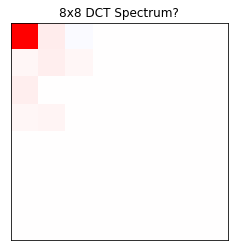

In [44]:
imgplot = plt.imshow(DCT_spectrum8x8np,cmap="bwr",vmin=-128,vmax=128)  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("8x8 DCT Spectrum?")

AC成分が小さいためコントラストがわかるように範囲も-128 to +128にしてある(そのためDC成分は表示上は頭打ち)  

さてここで、DCT逆変換によりもとの輝度値Yを復元する。  
これ[scipy](https://docs.scipy.org/doc/scipy/reference/)の[fftpack](http://scipy.github.io/devdocs/fftpack.html)モジュールの[idct()](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.fftpack.idct.html#scipy.fftpack.idct)を使う。  
JPEGではエンコーディング時のDCT変換前に0～255の輝度値を-128～+127になるようにしているので変化後の値には+128をして

In [45]:
import scipy as sp
import scipy.fftpack as fft

IDCT_Y=fft.idct(fft.idct(DCT_spectrum8x8np,n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')+128

In [46]:
(IDCT_Y).astype(int)

array([[163, 162, 161, 159, 157, 155, 155, 154],
       [160, 159, 158, 157, 156, 155, 154, 154],
       [156, 156, 156, 155, 154, 154, 154, 153],
       [155, 155, 155, 155, 154, 153, 153, 152],
       [156, 156, 156, 156, 155, 154, 153, 152],
       [156, 156, 157, 157, 156, 155, 154, 153],
       [155, 155, 156, 157, 157, 156, 155, 154],
       [153, 154, 155, 157, 157, 157, 156, 156]])

これを描画してみる。

Text(0.5, 1.0, 'first 8x8 block Y conp')

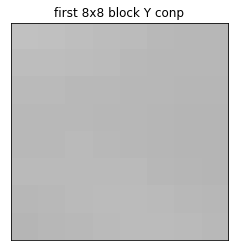

In [47]:
imgplot = plt.imshow(255-IDCT_Y,cmap="Greys",vmin=0,vmax=255)  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("first 8x8 block Y conp")

確認のため最初にmatplotlibのimread()で取り出したターゲット画像(img)より計算した輝度値Yを求め最初の画像を見てみる。

Text(0.5, 1.0, 'first 8x8 Y block of target')

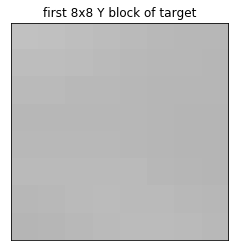

In [48]:
Y_img  =  0.29900 * img[:,:,0] + 0.58700  * img[:,:,1] + 0.11400 * img[:,:,2]
Cb_img = -0.16870 * img[:,:,0] - 0.33120  * img[:,:,1] + 0.50000 * img[:,:,2]
Cr_img =  0.50000 * img[:,:,0] - 0.41870  * img[:,:,1] - 0.08130 * img[:,:,2]
imgplot = plt.imshow(255-Y_img[0:8,0:8],cmap="Greys",vmin=0,vmax=255)  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("first 8x8 Y block of target")

In [49]:
(Y_img[0:8,0:8]).astype(int)

array([[164, 163, 161, 159, 157, 156, 154, 154],
       [160, 160, 159, 157, 156, 155, 154, 153],
       [157, 157, 156, 156, 155, 153, 153, 153],
       [155, 155, 155, 155, 155, 153, 152, 152],
       [156, 156, 156, 156, 155, 153, 152, 152],
       [157, 157, 157, 157, 156, 154, 154, 152],
       [155, 156, 156, 157, 156, 156, 156, 155],
       [152, 153, 155, 156, 157, 158, 157, 156]])

In [50]:
DCT_Y=fft.dct(fft.dct(Y_img[0:8,0:8]-128,n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')
DCT_Y.astype(int)

array([[225,   9,  -2,   0,   0,   0,   0,   0],
       [  4,   9,   3,   0,   0,   0,   0,   0],
       [  8,   0,   0,   0,   0,   0,   0,   0],
       [  3,   5,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

丸目誤差とかそういった程度の誤差はあるが再現できてるようである。

### 7.複数ブロックの復元

Y成分の先頭のブロックの復号が完成したの残りのブロック、成分の画素復元をする。

ここから詳しい情報がほしいので[JPEG (Joint Photographic Experts Group)](https://www.w3.org/Graphics/JPEG/)のサイトからITU勧告文書[ITU-T.81](https://www.w3.org/Graphics/JPEG/itu-t81.pdf)も確認した。。(変換のアルゴリズムも記載があったが、ここはpyhonのトレーニングということもあるし、今更なので参照しないことにする。)  

結果わかったことがあり、イメージデータは必ずしも全Y成分データすべて→全Cb成分データすべて→全Cb成分という順で構成されてないということ、、、、  
そしてここにきて謎だったSOF0セグメントのHn,Vnが意味がわかってきた、、

簡単な考えかたをするとHn,Ynは成分ごとの水平方向、垂直方向の成分ブロックの取り出し単位を表すようである。、、

JFIFのカラー画像(成分は1:Y,2:Cb,3:Crに限定される)の場合、元の画像データの成分1(Y)をH1×V1ブロック、成分2(Cb)をH2×V2ブロック、成分3(Cr)をH3×V3ブロックを一単位(これをMCU(Minimum Coded Unit)というらしい)としてMCUの繰り返しでイメージデータが保存されているとのこと。

今回のターゲットは


```
SOF0
  SEG LENGTH :  17
  P :  0
  Y : 150
  X : 150
  Nf :  3
  C1 : 1
  H1 : 2
  V1 : 2
  Tq1 : 0
  C2 : 2
  H2 : 1
  V2 : 1
  Tq2 : 1
  C3 : 3
  H3 : 1
  V3 : 1
  Tq3 : 1
 ```
 
 なので 
 Y成分2x2=4ブロック  
 Cb,Cr成分各1x1=1ブロック  
 それらをまとめたものが1MCUとなるようである。
 
 そして、Cr,Cbがブロックが少ない分はY成分のH,V(最大値)とのH,Vの比1/2に間引かれれて画素がサンプリングされているようである。
 
 MCUの中のブロックの並び方はジグザグでなく左上から右下へ行の折り返しでされている(横書きの文書と一緒)。
 
 また全画像中のMCUの並び方も左上から右下へ行の折り返しでされているとのこと。
 
 今回の場合はMCUの画素はVn,Hnの最大(Y成分)に合わせて2x2ブロック分つまり1MCU 16x16単位で全画素XxYは150x150なので10x10=100MCUあることになる。  
 
 とりあえずMCUに分割してから1MCUを取り出して分析してみる。
 
まずSOFフレーム,SOSフレームからも情報を取り出す。(JFIFフーマットのカラー画像に限定にしてるのでSOSフレームのCn等JFIFフォーマットで決まっている箇所は無視する。)


In [51]:

Q=[[],[],[],[]]
Ldc=[[],[],[],[]]
Vdc=[[],[],[],[]]
Lac=[[],[],[],[]]
Vac=[[],[],[],[]]

##テーブル数
nTdc=0
nTac=0

for seg in jpeg_struct:
    print(seg[0])

    if(seg[0] == "IMG"):
        print("  DATA LENGTH : ",seg[1],sep="")
    else:

        if(seg[0] == "SOI"):
            flag_SOI=True
        elif(seg[0] == "EOI"):
            flag_EOI=True
        else:
            print("  SEG LENGTH : ",seg[1])
            data=seg[2]

            
            ########       APP0   JFIFフォーマット       ######

            if(seg[0] == "APP0"):
                print("  ID : ",data[0:4].decode(),sep="")    #JFIF識別子
                print("  Ver : ",data[5],".",data[6],sep="")  #バージョン番号
                print("  U : ",data[7],sep="")                #ピクセル濃度の単位 0:不定 1:pixels/inch(dpi) 3: pixel/cm　
                print("  Xd : ",data[8]*256+data[9],sep="")   #縦のピクセル濃度
                print("  Yd : ",data[10]*256+data[11],sep="") #横のピクセル濃度
                print("  Xt : ",data[12],sep="")              #サムネイルイメージの横幅(サムネイル無なら0)
                print("  Yt : ",data[13],sep="")              #サムネイルイメージの高さ(サムネイル無なら0)             
                for i in range(data[12]*data[13]):          
                    print("  RGB",i," : (",data[14+i*3],",",data[15+i*3],",",data[16+i*3],")",sep="")
                                                                          #サムネイルイメージRGB値                    
                        
                        
            ########       DQT   量子化テーブル定義      ######

            elif(seg[0] == "DQT"):
                length = int(seg[1])-3
                base = 0
                while(length >0):
                    pqn=data[base]>>4
                    tqn=data[base]&0x0F;
                    if(pqn==0):
                        qlen=64;
                    else:
                        qlen=128;
                    print("  Pq",tqn," : ",pqn,sep="")         #量子化テーブル精度 0;8bit , 1:16bit
                    print("  Tq",tqn," : ",tqn,sep="")         #量子化テーブル番号 0 to 3
                    for i in range(qlen):
                        Q[tqn] += [data[base+1+i]]
                        #print("  Q",tqn,"-",ascii(i)," : ",data[base+1+i],sep="")
                                                               #量子化因子(量子化係数)
                    length-=qlen+1
                    base+=qlen+1

                    
            ########       SOF0 フレームタイプ0開始　(Baseline-DCT & ハフマン符号)   ######
            
            elif(seg[0] == "SOF0" or seg[0] == "SOF2"):
                Nf=data[5]
                ##print("  P : ",data[1])                             #サンプルの精度
                ##print("  Y : ",data[1]*256+data[2],sep="")         #画像縦サイズ
                Y=data[1]*256+data[2]
                ##print("  X : ",data[3]*256+data[4],sep="")         #画像横サイズ
                X=data[3]*256+data[4]
                Hmax=0
                Vmax=0
                h=[]
                v=[]
                Tq=[]
                ##print("  Nf : ",data[5])                           #構成要素数 1;GreyScacle ,3;YCbCr or YIQ 4;CMYK]
                for i in range(Nf):
                    #print("  C",i+1," : ",data[6+i*3],sep="")      #構成要素 識別子 1:Y 2:Cb 3:Cr 4:I 5:Q
                    #print("  H",i+1," : ",data[7+i*3]>>4,sep="")   #構成要素サ 水平方向ンプル化要因(比率)
                    h+=[data[7+i*3]>>4]
                    Hmax=h[i]if(h[i]>Hmax)else Hmax
                    #print("  V",i+1," : ",data[7+i*3]&0x0F,sep="") #構成要素 垂直報告サンプル化要因(比率)
                    v+=[data[7+i*3]&0x0F]
                    Vmax=v[i]if(v[i]>Vmax)else Vmax
                    #print("  Tq",i+1," : ",data[8+i*3],sep="")     #構成要素 量子化テーブル番号
                    Tq+=[data[8+i*3]]
 
            ########       DHT   ハフマン符号テーブル定義      ######

            elif(seg[0] == "DHT"):
                thn=data[0]&0x0f
                tcn=data[0]>>4
                print("  Tc",thn," : ",tcn,sep="")                          #クラス 0;DC , 1:1AC ？？
                print("  Th",thn," : ",thn,sep="")                          #ハフマン符号テーブル番号

                #テーブル数カウント
                if(thn==0):
                    nTdc+=1
                else:
                    nTac+=1
                    
                vlen=[]
                for i in range(16):
                    vlen+= [data[1+i]]
                    if(tcn==0):      #DCテーブル
                        Ldc[thn]+=[data[1+i]]
                    else:            #ACテーブル
                        Lac[thn]+=[data[1+i]]
                    #print("  L",i+1," ; ",data[1+i],sep="")          #符号長ごとの符号数
                
                base = 17

                for i in range(16):
                    vlist=[]
                    for j in range(vlen[i]):
                        if(tcn==0):      #DCテーブル
                            vlist+=[data[base+j]]
                            #print("  V",i+1,"-",j+1," : ",data[base+j],sep="")
                                                   #各符号長の符号(tcn=0のとき)　データービット数
                        else:            #ACテーブル
                            runlen=data[base+j]>>4
                            detalen=data[base+j]&0x0F
                            
                            if(detalen==0):
                                if(runlen==0):
                                    vlist+=[("EOB",0)]
                                elif(runlen==15):
                                    vlist+=[("ZRL",0)]
                                else:
                                    vlist+=[("N/A",0)]
                            else:
                                vlist+=[(runlen,detalen)]
                            #print("  V",i+1,"-",j+1," : ",data[base+j]>>4,",",data[base+j]&0x0F,sep="")
                                                   #各符号長の符号(tcn=1のとき) ランレングス数、データービット数                         
                    if(tcn==0):      #DCテーブル
                        Vdc[thn]+=[vlist]
                    else:           #ACテーブル
                        Vac[thn]+=[vlist]
                    base+=vlen[i]

            ########       SOS   Start Of Scan      ######                    
                    
            elif(seg[0] == "SOS"):
                Ns=data[0]
                ##print("  Ns : ",ns)                                   #構成要素の数
                Td=[]
                Ta=[]
                for i in range(Ns):
                    ##print("  Cs",i+1," : ",data[1+i*2],sep="")        #構成要素 識別子
                    ##print("  Td",i+1," : ",data[2+i*2]>>4,sep="")     #構成要素 DC成分ハフマン符号テーブル番号
                    Td+=[data[2+i*2]>>4]
                    ##print("  Ta",i+1," : ",data[2+i*2]&0x0F,sep="")   #構成要素 AC成分ハフマン符号テーブル番号
                    Ta+=[data[2+i*2]&0x0F]
                ##print("  Ss : ",data[1+ns*2],sep="")                   #スペクトル選択開始(量子化係数開始番号)
                ##print("  Se : ",data[2+ns*2],sep="")                   #スペクトル選択終了量子化係数開始終了)
                ##print("  Ah : ",data[3+ns*2]>>4,sep="")                #？？
                ##print("  Al : ",data[3+ns*2]&0x0f,sep="")              #？？

SOI
APP0
  SEG LENGTH :  16
  ID : JFIF
  Ver : 1.1
  U : 1
  Xd : 72
  Yd : 72
  Xt : 0
  Yt : 0
DQT
  SEG LENGTH :  67
  Pq0 : 0
  Tq0 : 0
DQT
  SEG LENGTH :  67
  Pq1 : 0
  Tq1 : 1
SOF0
  SEG LENGTH :  17
DHT
  SEG LENGTH :  31
  Tc0 : 0
  Th0 : 0
DHT
  SEG LENGTH :  181
  Tc0 : 1
  Th0 : 0
DHT
  SEG LENGTH :  31
  Tc1 : 0
  Th1 : 1
DHT
  SEG LENGTH :  181
  Tc1 : 1
  Th1 : 1
SOS
  SEG LENGTH :  12
IMG
  DATA LENGTH : 6594
EOI


floatからintのキャストは切り捨てなのでx軸,y軸方向のmcu数の算出は画素数/MCU画素数が割り切れない場合は+1する。  
3項演算子としての (true) if (condition) else (false)を使ってみる。  

(condition) ? (True) : (False) 形式に慣れてるのでややこしい、、  

以下コードで10x10=100になるはず

In [52]:
mcu_size_x=8*Hmax
mcu_size_y=8*Vmax

X_mcus=X/mcu_size_x if(X%mcu_size_x==0)else int(X/mcu_size_x)+1 ##X方向のMCU数
Y_mcus=Y/mcu_size_y if(Y%mcu_size_y==0)else int(Y/mcu_size_y)+1 ##Y方向のMCU数
print(X_mcus,Y_mcus)

10 10


MCU内の成分ごとのブロック数構成を定義

In [53]:
mcu_struct=[]
for i in range(Ns):
    mcu_struct+=[[h[i]*v[i],(v[i],h[i])]]
print(mcu_struct)

[[4, (2, 2)], [1, (1, 1)], [1, (1, 1)]]


In [54]:
##ハフマンツリー構成
H_tree_dc_org=[]
H_tree_ac_org=[]
for i in range(nTac):
    Tree,alist=huffman_tree(Ldc[i])
    H_tree_dc_org+=[Tree]
    
for i in range(nTac):  
    Tree,alist=huffman_tree(Lac[i])
    H_tree_ac_org+=[Tree]

#MCUの格納リスト
MCUs=[]

##MCUのカウント
mcus=0

##1MCU初期化
MCU=[]

##成分(初期値0)
comp=0

##各成分のDC成分の初期化
data_dc_latest=[0,0,0,0]

#MCUの各成分内のblocks数のカウント初期化
blocks=0

##成分のブロック数/MCU
blocks_max=mcu_struct[comp][0]


#ジグザグスキャン番号初期化
zz=0


flag_data=False
flag_code=False
d_bits=0
h_bits=0
data=0
edata=0

##8x8 ブロックデータ
decoded=[]

##最初はDC
H_tree=H_tree_dc_org[Td[comp]]
V=Vdc[Td[comp]]

for byte in jpeg_struct[10][2]:
    #print("(","{:2X}".format(byte),")",end="",sep="")
    mask=int(0x80)
    for i in range(8):
        bit=(byte&mask!=0)
        if(mcus>=X_mcus*Y_mcus):print("1" if bit else "0",end="")
        #print("1" if bit else "0",end="")
        
        #Huffman符号取り出し
        if(flag_data==False):

            if(bit==False):  #符号0
                element=H_tree[0]
            else:             #符号1
                element=H_tree[1]
                
            h_bits+=1
                    
            if(type(element)==tuple):
                H_tree=element
                
            #Huffmanコード検出
            else:
                if(zz==0):
                    #print("")
                    #print("zz:",zz," , dc_hufbits:",h_bits," , elm=",element,sep="")
                    #print("Vdc",h_bits,"-",element+1,":",V[h_bits-1][element],sep="")
                    data_len=V[h_bits-1][element]
                else:
                    #print("")
                    #print("zz:",zz," , ac_hufbits:",h_bits," , elm=",element,sep="")
                    #print("Vac",h_bits,"-",element+1,":",V[h_bits-1][element],sep="")
                    data_len=V[h_bits-1][element][1]
                
                if(data_len==0):#databit長0ならそのままエンコード
                    flag_code=True
                else:
                    flag_data=True
                    
        #databit取り出し
        elif(data_len > 0): 
            data*=2              
            data+= 1if(bit) else 0
            d_bits+=1
            
            #databit(code)終了
            if(d_bits==data_len):
                #print("")
                #print("zz:",zz," , databits:" ,d_bits," , data=",data,sep="")
                flag_code=True
                
        
        #decode処理
        if(flag_code==True):
            #print("")
            #print("V",h_bits,"-",element+1,":",V[h_bits-1][element],sep="")
            
            #czgzbit復号
            if(data_len==0):
                ddata=0;
            else:
                if(data & (1 << (data_len-1))!=0):
                    ddata=data
                else:
                    ddata=-(data^((1<<data_len)-1))
                    
            #格納
            if(zz==0):
                ##print("debug Vdc",zz,V[h_bits-1][element])]
                #print("(DC)decode[",zz,"]=", data_dc_latest[comp],"+",ddata,"=",ddata+data_dc_latest[comp],sep="")
                data_dc_latest[comp]+=ddata
                decoded=[data_dc_latest[comp]];

                zz+=1
            else:
                ##print("debug Vac",zz,V[h_bits-1][element])
                if(type(V[h_bits-1][element][0])==int):
                    for j in range(V[h_bits-1][element][0]):
                        if(zz<64):
                            #print("decode[",zz,"]=",0,sep="")
                            decoded+=[0]
                            zz+=1
                    if(zz<64):
                        #print("decode[",zz,"]=",ddata,sep="")
                        decoded+=[ddata]
                        zz+=1
                elif(V[h_bits-1][element][0]=="EOB"):
                     while(zz<64):
                        #print("decode[",zz,"]=",0,sep="")
                        decoded+=[0]
                        zz+=1                 
                elif(V[h_bits-1][element][0]=="ZRL"):
                     for j in range(16):
                        if(zz<64):
                            #print("decode[",zz,"]=",zz,0,sep="")
                            decoded+=[0]
                            zz+=1
                            
            flag_code=False
            flag_data=False
            d_bits=0
            h_bits=0
            data=0
            
            ##ブロック終了
            if(zz==64):
                #print("*********   comp=",comp," brock=",blocks," >fin",sep="")
                MCU+=[decoded]
                decoded=[]
                blocks+=1
                                    
                ##成分終了
                if(blocks==blocks_max):
                    #print("********************   comp:",comp," >fin",sep="")
                    blocks=0
                    comp+=1
                    
                    ##MCU終了
                    if(comp==Ns):
                        #print("****************************   MCU=",mcus," >fin",sep="")
                        #print("")
                        MCUs+=[MCU]
                        MCU=[]
                        mcus+=1
                        comp=0
                        
                    blocks_max=mcu_struct[comp][0]
                    
                #print("Td[",comp,"]:",Td[comp],sep="")    
                H_tree=H_tree_dc_org[Td[comp]]  
                V=Vdc[Td[comp]]
                zz=0
                
            else:
                #print("Ta[",comp,"]:",Ta[comp],sep="")
                H_tree=H_tree_ac_org[Ta[comp]]
                V=Vac[Ta[comp]]
              
        #if(mcus==4):break    
        mask= mask >>1 
    #if(mcus==4):break  


111111

In [55]:
len(MCUs)

100

In [56]:
len(MCUs[0])

6

MCU数はちゃんと100になったし、最初のMCUの1MCUあたりの要素数も6なのでたぶんできた。

逆量子化とジグザグスキャンの二次元配列化

In [57]:
dqMCUs=[]

for mcu in MCUs:
    dqMCU=[]
    blocks=0
    comp=0
    for data64 in mcu:
        dequantized=[]
        for y in range(8):
            buf=[]
            for x in range(8):
                buf+=[data64[dic_zigzag[(x,y)]]*Q[Tq[comp]][dic_zigzag[(x,y)]]]
            dequantized+=[buf]
            
        #print(blocks,comp)           

        dqMCU+=[dequantized]
        
        blocks+=1
        if(blocks==mcu_struct[comp][0]):
            blocks=0
            comp+=1
            
  
    dqMCUs+=[dqMCU]

In [58]:
dqMCUs[0][4]

[[-230, 10, 0, 0, 0, 0, 0, 0],
 [5, 6, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0]]

16x16の３成分ごのの画素の配列に並び替えてみる。とりあえずは力技で、、、  
まずスペクトルのまま配置Cr,Cbの8x8は左上につめて、、

In [59]:
mcu_id=0
Y_spectrum=[]
Cb_spectrum=[]
Cr_spectrum=[]
for y in range(mcu_size_y):
    buf_Y=[]
    buf_Cb=[]
    buf_Cr=[]
    for x in range(mcu_size_x):
        blk_num=int(y/8)*2+int(x/8)
        buf_Y+=[dqMCUs[mcu_id][blk_num][y%8][x%8]]
      
        if((x<8 )& (y<8)):
            buf_Cb+=[dqMCUs[mcu_id][4][y][x]]
            buf_Cr+=[dqMCUs[mcu_id][5][y][x]]
        else:
            buf_Cb+=[0]
            buf_Cr+=[0]
    
    Y_spectrum+=[buf_Y]
    Cb_spectrum+=[buf_Cb]
    Cr_spectrum+=[buf_Cr]

とりあえず各成分のスペクトルを描いてみる

Text(0.5, 1.0, 'Cr')

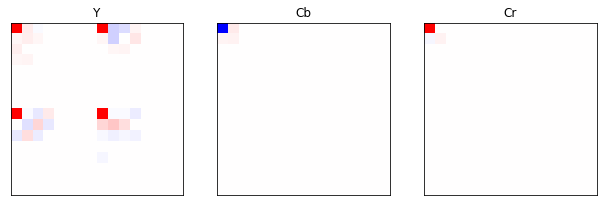

In [60]:
Y_spectrum_np=np.array(Y_spectrum,float)
Cb_spectrum_np=np.array(Cb_spectrum,float)
Cr_spectrum_np=np.array(Cr_spectrum,float)

fig, axs = plt.subplots(1, 3,figsize=[10.5,3.5])   #1x3のマルチっプロットの作成

axs[0].imshow(Y_spectrum_np,cmap="bwr",vmin=-128,vmax=128)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Y")

axs[1].imshow(Cb_spectrum_np,cmap="bwr",vmin=-128,vmax=128)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Cb")

axs[2].imshow(Cr_spectrum_np,cmap="bwr",vmin=-128,vmax=128)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Cr")

さてDCT逆変換して、変換結果を描いてみる。

何度か悩んでDC成分は前のブロックとの差(最初のブロックのみ絶対値)であるということをしった。

Text(0.5, 1.0, 'Cr')

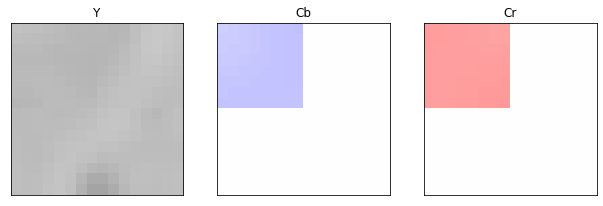

In [61]:

idct_Y=np.zeros((16,16),float)
idct_Cr=np.zeros((16,16),float)
idct_Cb=np.zeros((16,16),float)
idct_Y[0:8,0:8]=fft.idct(fft.idct(Y_spectrum_np[0:8,0:8],n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')+128
idct_Y[0:8,8:16]=fft.idct(fft.idct(Y_spectrum_np[0:8,8:16],n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')+128
idct_Y[8:16,0:8]=fft.idct(fft.idct(Y_spectrum_np[8:16,0:8],n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')+128
idct_Y[8:16,8:16]=fft.idct(fft.idct(Y_spectrum_np[8:16,8:16],n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')+128

idct_Cb[0:8,0:8]=fft.idct(fft.idct(Cb_spectrum_np[0:8,0:8],n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')
idct_Cr[0:8,0:8]=fft.idct(fft.idct(Cr_spectrum_np[0:8,0:8],n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')

fig, axs = plt.subplots(1, 3,figsize=[10.5,3.5])   #1x3のマルチっプロットの作成

axs[0].imshow(255-idct_Y,cmap="Greys",vmin=0,vmax=256)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Y")

axs[1].imshow(idct_Cb,cmap="bwr",vmin=-128,vmax=128)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Cb")

axs[2].imshow(idct_Cr,cmap="bwr",vmin=-128,vmax=128)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Cr")

いい感じ

Cbは8x8に間引いてるので、当然復号化したものは左上の8x8の部分しか成分がない、

さて、実際ターゲット画像の同じ4ブロック(左上)と輝度値(Y成分)を今回復号化したY成分と比べてみる。

Text(0.5, 1.0, 'decoded Ycomp16x16')

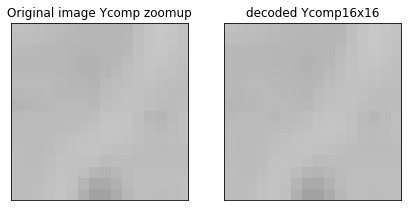

In [62]:
fig, axs = plt.subplots(1, 2,figsize=[7.,3.5])   #1x2のマルチっプロットの作成

axs[0].imshow(255-(Y_img[0:16,0:16]).astype(int),cmap="Greys",vmin=0,vmax=256)  
axs[0].axes.set_xticks([]) #x軸の目盛を削除
axs[0].axes.set_yticks([]) #y軸の目盛を削除
axs[0].axes.set_title("Original image Ycomp zoomup" )

axs[1].imshow(255-idct_Y.astype(int),cmap="Greys",vmin=0,vmax=256)  
axs[1].axes.set_xticks([]) #x軸の目盛を削除
axs[1].axes.set_yticks([]) #y軸の目盛を削除
axs[1].axes.set_title("decoded Ycomp16x16" )

In [63]:
idct_Cb=fft.idct(fft.idct(Cb_spectrum_np,n=16,axis=0,norm='ortho'),n=16,axis=1,norm='ortho')*2
idct_Cr=fft.idct(fft.idct(Cr_spectrum_np,n=16,axis=0,norm='ortho'),n=16,axis=1,norm='ortho')*2

16x16に間引く都合係数が変わるのでその分2をかける。

一応補足すると[scipy](https://docs.scipy.org/doc/scipy/reference/)の[idct()](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.fftpack.idct.html#scipy.fftpack.idct)をのリファランスによると 一次元のDCT逆変換は特にtype指定なしだとTYPE3のDCT変換と同じ(type2の逆変換)になって、norm='ortho'指定した場合以下になる。($F(n)$がスペクトル$f(k)$は元データNはスペクトル数今回は8とか16とか)

$$f(k) = F(0)/\sqrt{N} + \sqrt{2/N}  \sum_{n=1}^{N-1}{F(n)\cos(\pi(k+0.5)n/N)}$$

で2次元の場合は

$$f(k,j) = F(0,0)/N + 2/N  \sum_{n=1}^{N-1} \sum_{m=1}^{N-1}{F(n,m)\cos(\pi(k+0.5)n/N)}\cos(\pi(j+0.5)m/N)$$

で、係数はDC成分で$1/N$、AC成分で$2/N$となるので、$N=8$で変換したいものを$N=16$で変換すると半分になるのでその補正で2をかけてる。
それでCb,Crを16x16の画素値を取り出してRGBに変換してカラー画像で再現してみる。

Text(0.5, 1.0, 'decodedl data RGB image')

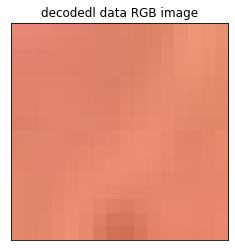

In [64]:
red_img   = idct_Y                   + 1.4020 *idct_Cr
green_img = idct_Y - 0.3440 *idct_Cb - 0.7141 *idct_Cr
blue_img  = idct_Y + 1.7720 *idct_Cb

img16x16=np.ndarray((16,16,3),dtype=int)
img16x16[:,:,0]=red_img
img16x16[:,:,1]=green_img
img16x16[:,:,2]=blue_img

imgplot = plt.imshow(img16x16)  
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("decodedl data RGB image" )

オリジナルイメージと比べてみる。

Text(0.5, 1.0, 'decoded collor img 16x16')

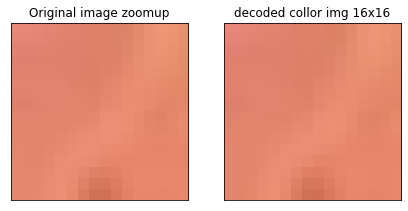

In [65]:
fig, axs = plt.subplots(1, 2,figsize=[7.,3.5])   #1x2のマルチっプロットの作成

axs[0].imshow(img[0:16,0:16,:])  
axs[0].axes.set_xticks([]) #x軸の目盛を削除
axs[0].axes.set_yticks([]) #y軸の目盛を削除
axs[0].axes.set_title("Original image zoomup" )

axs[1].imshow(img16x16)  
axs[1].axes.set_xticks([]) #x軸の目盛を削除
axs[1].axes.set_yticks([]) #y軸の目盛を削除
axs[1].axes.set_title("decoded collor img 16x16" )

なんとか1MCU分(16x16画素)のカラー画像の復元ができた。

これから全MCU復元していく。





### 8.全画像の復元

全MCUを10×10つまり160x160pixelに並べてデータを復元する。
画像サイズは画像は150x150だけど16x16単位だと端数なので右10pixel、左10pixelは無駄データが作られるが、、、一応これも再現してみる。

まず入れ物をdct_spectrum_npという名称で用意

先ほど計算したmcu_size_x,mcu_size_y(1MCUの画素サイズ)とX_mcus,Y_mcus(画像全体のMCUのx方向列数とy方向行数)をつかう(冗長だけどわかりやすいようにもう一度計算のcodeを記述しておく)

汎用性を持たせるため成分は成分番号としてここでは特段YCbCrは分けないようにしておく

In [66]:
mcu_size_x=8*Hmax
mcu_size_y=8*Vmax

X_mcus=X/mcu_size_x if(X%mcu_size_x==0)else int(X/mcu_size_x)+1 ##X方向のMCU数
Y_mcus=Y/mcu_size_y if(Y%mcu_size_y==0)else int(Y/mcu_size_y)+1 ##Y方向のMCU数

dct_spectrum_np=np.zeros((mcu_size_y*Y_mcus,mcu_size_x*X_mcus,Nf),float)


print(dct_spectrum_np.shape)

(160, 160, 3)


左上から右下にかけて行、列の順番で単位で処理していくので100あるMCU(0番to99番)までの左上の位置は配列上

各MCUの画素の左上の位置は以下のようになるそこを基準(左)にした16x16画素MCU(厳密にはmcu_size_y x mcu_size_x)を並べていく

In [67]:
for i in range(len(MCUs)):
    print("MCU[","{:2d}".format(i),"]:(y,x)=",(int(i/Y_mcus)*mcu_size_y,i%X_mcus*mcu_size_x))

MCU[  0 ]:(y,x)= (0, 0)
MCU[  1 ]:(y,x)= (0, 16)
MCU[  2 ]:(y,x)= (0, 32)
MCU[  3 ]:(y,x)= (0, 48)
MCU[  4 ]:(y,x)= (0, 64)
MCU[  5 ]:(y,x)= (0, 80)
MCU[  6 ]:(y,x)= (0, 96)
MCU[  7 ]:(y,x)= (0, 112)
MCU[  8 ]:(y,x)= (0, 128)
MCU[  9 ]:(y,x)= (0, 144)
MCU[ 10 ]:(y,x)= (16, 0)
MCU[ 11 ]:(y,x)= (16, 16)
MCU[ 12 ]:(y,x)= (16, 32)
MCU[ 13 ]:(y,x)= (16, 48)
MCU[ 14 ]:(y,x)= (16, 64)
MCU[ 15 ]:(y,x)= (16, 80)
MCU[ 16 ]:(y,x)= (16, 96)
MCU[ 17 ]:(y,x)= (16, 112)
MCU[ 18 ]:(y,x)= (16, 128)
MCU[ 19 ]:(y,x)= (16, 144)
MCU[ 20 ]:(y,x)= (32, 0)
MCU[ 21 ]:(y,x)= (32, 16)
MCU[ 22 ]:(y,x)= (32, 32)
MCU[ 23 ]:(y,x)= (32, 48)
MCU[ 24 ]:(y,x)= (32, 64)
MCU[ 25 ]:(y,x)= (32, 80)
MCU[ 26 ]:(y,x)= (32, 96)
MCU[ 27 ]:(y,x)= (32, 112)
MCU[ 28 ]:(y,x)= (32, 128)
MCU[ 29 ]:(y,x)= (32, 144)
MCU[ 30 ]:(y,x)= (48, 0)
MCU[ 31 ]:(y,x)= (48, 16)
MCU[ 32 ]:(y,x)= (48, 32)
MCU[ 33 ]:(y,x)= (48, 48)
MCU[ 34 ]:(y,x)= (48, 64)
MCU[ 35 ]:(y,x)= (48, 80)
MCU[ 36 ]:(y,x)= (48, 96)
MCU[ 37 ]:(y,x)= (48, 112)
MCU[ 38 ]:(y,x)=

これらの位置を基準として先ほど力技でやったMCU→各成分に変換するスペクトルを配置してみる。    
まず、先ほどの力技codeをスマートにモディファイしつつ任意の1MCUを格納する機能を関数定義する  
(先ほどはlist型だったのを今度はndarray型になっていることも反映)

先ほどのmcu内の構成を表すmcu_structも引数とする。(引数だけで処理することを意識してmcu_size_x,mcu_size_yやX_mcus,Y_mcusは関数内で使わないでmcu_structから計算することにする。

In [68]:
mcu_struct=[]
for i in range(Ns):
    mcu_struct+=[[v[i]*h[i],(v[i],h[i])]]
print(mcu_struct)

[[4, (2, 2)], [1, (1, 1)], [1, (1, 1)]]


In [69]:
def MCU_place (mcu_spectrum,nf,MCU,mcu_struct):
    
    i=0
    for comp in range(ns):
        for Y_block in range(mcu_struct[comp][1][0]):
            for X_block in range(mcu_struct[comp][1][1]): 
                for y in range(8):
                    for x in range(8):
                        mcu_spectrum[Y_block*8+y,X_block*8+x,comp]=MCU[i][y][x]
                i+=1



pythonのインデントで処理のレベルが決まるところは苦手、、、こういうコードでi+=1のインデント位置の間違いに気づきにくい（慣れの問題？？）、、、

この関数を使いってMCUからスペクトルを取り出して前述のMCU並べ方で配列dct_spectrum_npに配置していく

In [70]:
for i in range(len(dqMCUs)):
    y_base=int(i/Y_mcus)*mcu_size_y
    x_base=(i%X_mcus)*mcu_size_x
    MCU_place(dct_spectrum_np[y_base:y_base+mcu_size_y,x_base:x_base+mcu_size_x,:],Nf,dqMCUs[i],mcu_struct)

Text(0.5, 1.0, 'Cr')

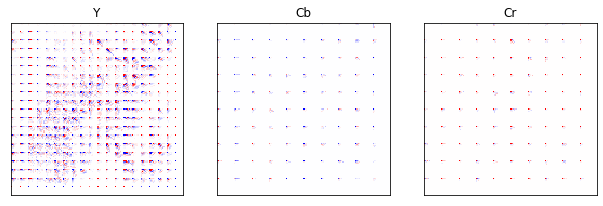

In [71]:
fig, axs = plt.subplots(1, 3,figsize=[10.5,3.5])   #1x3のマルチっプロットの作成

axs[0].imshow(dct_spectrum_np[:,:,0].astype(int),cmap="bwr",vmin=-128,vmax=128)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Y")

axs[1].imshow(dct_spectrum_np[:,:,1].astype(int),cmap="bwr",vmin=-128,vmax=128)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Cb")

axs[2].imshow(dct_spectrum_np[:,:,2].astype(int),cmap="bwr",vmin=-128,vmax=128)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Cr")

In [72]:
dct_spectrum_np[0:16,0:16,0].astype(int)

array([[225,   9,  -3,   0,   0,   0,   0,   0, 275, -24, -18,   5,   0,
          0,   0,   0],
       [  4,   8,   4,   0,   0,   0,   0,   0,   4, -24,   0,  12,   0,
          0,   0,   0],
       [  8,   0,   0,   0,   0,   0,   0,   0,   0,   4,   5,   0,   0,
          0,   0,   0],
       [  4,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [255,  -3, -12,  10,   0,   0,   0,   0, 255,  -3,  -3, -10,   0,
          0,   0,   0],
       [  0, -16,  20, -12,   0,   0,   0,   0,  20,  28,  16,   0,   0,
          0,   0,   0],
       [-12,  16, -10,   0,   

こんな感じでスペクトルだけならべてみた、Y成分のスペクトルのプロットには元画像の面影がうっすらと見える。

次にDCT逆変換、変換は先ほどのMCU_placeの処理と一緒にやるほうがよさそうそれをモディファイしてみる。

In [73]:
def MCU_IDC_place (mcu_imgs,nf,MCU,mcu_struct):
    
    hmax=0
    vmax=0
    for comp_para in mcu_struct:
        if(comp_para[1][0]>vmax):vmax=comp_para[1][0]
        if(comp_para[1][1]>hmax):hmax=comp_para[1][1]
    
    
    i=0
    for comp in range(ns):
        v_n=int(vmax/mcu_struct[comp][1][0])
        h_n=int(hmax/mcu_struct[comp][1][1])
        mcu_spectrum=np.zeros((vmax*8,hmax*8))
        #print(mcu_spectrum.shape)
        for Y_block in range(mcu_struct[comp][1][0]):
            for X_block in range(mcu_struct[comp][1][1]): 
                #print("block ",i,"th:comp=",comp,":(Y,X)=(",Y_block,",",X_block,"):(v,h)=(",v_n,",",h_n,")",sep="")
                for y in range(8):
                    for x in range(8):
                        mcu_spectrum[Y_block*8+y,X_block*8+x]=MCU[i][y][x]
                        
                mcu_imgs[ Y_block*8 : Y_block*8 + 8*v_n , X_block*8 : X_block*8 + 8*h_n , comp]= \
                    fft.idct(fft.idct(mcu_spectrum[Y_block*8 : Y_block*8 + 8*v_n , X_block*8 : X_block*8 + 8*h_n],n=8*v_n,axis=0,norm='ortho')\
                         ,n=8*h_n,axis=1,norm='ortho')*np.sqrt(v_n*h_n)        
                
                #mcu_imgs[ Y_block*8 : Y_block*8 + 8*v_n , X_block*8 : X_block*8 + 8*h_n , comp]=0
 
                i+=1
        
        
        


入れ物もdecoded_YCbCr_npとして新しく作って上記関数をMCUごとにIDCT変換したものを並べてみる。

Text(0.5, 1.0, 'Cr')

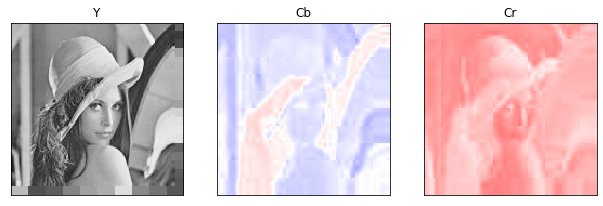

In [74]:
decoded_YCbCr_np=np.zeros((mcu_size_y*Y_mcus,mcu_size_x*X_mcus,Ns),float)


for i in range(len(dqMCUs)):
    y_base=int(i/Y_mcus)*mcu_size_y
    x_base=(i%X_mcus)*mcu_size_x
    #print("*************** MCU",i,":(y_base,x_base)=(",y_base,",",x_base,")",sep="")
    MCU_IDC_place(decoded_YCbCr_np[y_base:y_base+mcu_size_y,x_base:x_base+mcu_size_x,:],Nf,dqMCUs[i],mcu_struct)

fig, axs = plt.subplots(1, 3,figsize=[10.5,3.5])   #1x3のマルチっプロットの作成

axs[0].imshow(256-decoded_YCbCr_np[0:,0:,0].astype(int)-128,cmap="Greys",vmin=0,vmax=256)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("Y")

axs[1].imshow(decoded_YCbCr_np[:,:,1].astype(int),cmap="bwr",vmin=-128,vmax=128)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Cb")

axs[2].imshow(decoded_YCbCr_np[:,:,2].astype(int),cmap="bwr",vmin=-128,vmax=128)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Cr")

どうやらうまく言った雰囲気なのでRGB合成と16x160から左上150x150のをしてプロットしてみる

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'decodedl data RGB image')

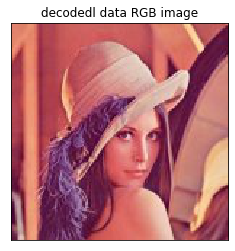

In [75]:
dec_red_img  = decoded_YCbCr_np[0:Y,0:X,0] +128 + 1.4020 *decoded_YCbCr_np[0:Y,0:X,2]
dec_green_img = decoded_YCbCr_np[0:Y,0:X,0] +128 - 0.3440 *decoded_YCbCr_np[0:Y,0:X,1]  - 0.7141 *decoded_YCbCr_np[0:Y,0:X,2] 
dec_blue_img  = decoded_YCbCr_np[0:Y,0:X,0] +128 + 1.7720 *decoded_YCbCr_np[0:Y,0:X,1] 


decoded_img=np.ndarray((Y,X,Ns),dtype=int)
decoded_img[:,:,0]=dec_red_img.astype(int)
decoded_img[:,:,1]=dec_green_img.astype(int)
decoded_img[:,:,2]=dec_blue_img.astype(int)

imgplot = plt.imshow(decoded_img)  
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("decodedl data RGB image" )


ちょっと画素範囲(0-255)からはみ出てクリッピングされてる値があるみたいで文句をいわれているがうまく言った感じである。

最後にターゲットのオリジナル画像と並べてみる。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'decoded collor img')

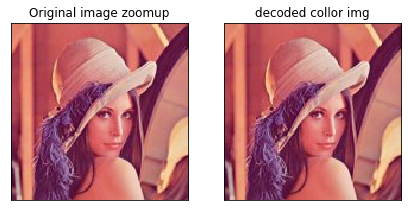

In [76]:
fig, axs = plt.subplots(1, 2,figsize=[7.,3.5])   #1x2のマルチっプロットの作成

axs[0].imshow(img)  
axs[0].axes.set_xticks([]) #x軸の目盛を削除
axs[0].axes.set_yticks([]) #y軸の目盛を削除
axs[0].axes.set_title("Original image zoomup" )

axs[1].imshow(decoded_img)  
axs[1].axes.set_xticks([]) #x軸の目盛を削除
axs[1].axes.set_yticks([]) #y軸の目盛を削除
axs[1].axes.set_title("decoded collor img" )